# Functions and imports

Imports and the functions that call the HI-VAE, modified from the paper version only to allow inputting s_codes and z_codes manually.

In [2]:
import time
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import os
import re
import pandas as pd
import numpy as np
from IPython.display import Audio
import seaborn as sns

import helpers # this is where the main training/decoding functions are, modified from teh original HIVAE main.py

#import warnings 
#warnings.filterwarnings('ignore') ########## NOTE: comment out for testing in case it's hiding problems

def set_settings(opts,nepochs=500,modload=False,save=True): # note: modload doesnt do anything right now, hardcoded in helpers.py
    'replace setting template placeholders with file info'
    inputf=re.sub('.csv','',opts['files'].iloc[0])
    missf=inputf+'_missing.csv'
    typef=inputf+'_types.csv'
    
    template = '--epochs NEPOCHS --model_name model_HIVAE_inputDropout --restore MODLOAD \
        --data_file data_python/INPUT_FILE.csv --types_file data_python/TYPES_FILE \
         --batch_size NBATCH --save NEPFILL --save_file SAVE_FILE\
        --dim_latent_s SDIM --dim_latent_z 1 --dim_latent_y YDIM \
        --miss_percentage_train 0 --miss_percentage_test 0 \
        --true_miss_file data_python/MISS_FILE --learning_rate LRATE'
    
    # replace placeholders in template
    settings = re.sub('INPUT_FILE',inputf,template)
    settings = re.sub('NBATCH',str(opts['nbatch'].iloc[0]),settings)
    settings = re.sub('NEPOCHS',str(nepochs),settings)
    settings = re.sub('NEPFILL',str(nepochs-1),settings) if save else re.sub('NEPFILL',str(nepochs*2),settings)
    settings = re.sub('YDIM',str(opts['ydims'].iloc[0]),settings)
    settings = re.sub('SDIM',str(opts['sdims'].iloc[0]),settings)
    settings = re.sub('MISS_FILE',missf,settings) #if not 'medhist' in inputf else re.sub('--true_miss_file data_python/MISS_FILE','',settings)
    settings = re.sub('TYPES_FILE',typef,settings)
    settings = re.sub('SAVE_FILE',inputf,settings)
    settings = re.sub('LRATE',str(opts['lrates'].iloc[0]),settings)
    settings = re.sub('MODLOAD','1',settings) if modload else re.sub('MODLOAD','0',settings)
    
    return settings

In [3]:
os.getcwd()

'/Users/meemansasood/Documents/Documents_IT/paper/Altoida_VAMBN_paper/data/HI-VAE'

In [4]:
sample_size=178
# get file list
files=[i for i in os.listdir('data_python/') if not '_type' in i and not '_missing' in i and i not in '.DS_Store']
files.sort()
print(len(files))

12


In [4]:
best_hyper=pd.read_csv('results_AltoidaDec2021.csv',  sep = ',')
best_hyper = best_hyper.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
best_hyper.files = best_hyper.files.str.replace('\\_grid.*?\\_results', '')
#best_hyper = best_hyper[~best_hyper.files.str.contains("MMSE")]
best_hyper

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,loss,lrates,nbatch,wdecay,ydims,files
0,0.727798,0.001,32.0,0.001,1.0,MMSE_Orientation.csv
1,-288.996748,0.010,16.0,0.000,1.0,ARPlaceAndFindTelemetryVariance.csv
2,22.338994,0.010,16.0,0.000,1.0,ARScreenButtonPresses.csv
3,26.113729,0.001,16.0,0.000,1.0,ARObjectFinding.csv
4,70.346922,0.010,16.0,0.000,1.0,MotorDrawingFeatures.csv
5,14.976143,0.001,16.0,0.000,1.0,MotorTappingFeatures.csv
6,3.912904,0.010,16.0,0.001,1.0,BITDOTMotorInstructionReadingTimeRatios.csv
7,0.051615,0.010,32.0,0.000,1.0,MMSE_Working_Memory_Registration.csv
8,54.912515,0.010,16.0,0.000,1.0,MotorTestDurations.csv
9,1.074809,0.010,32.0,0.000,1.0,MMSE_Memory_Recall.csv


In [5]:
sample_size=178
# get file list
files=[i for i in os.listdir('data_python/') if not '_type' in i and not '_missing' in i and i not in '.DS_Store']
files.sort()
best_hyper = best_hyper.sort_values('files')
best_hyper = best_hyper.reset_index(drop=True)
#sds =[1,2,4,2,2,2,2,2,1,4,2,3,4,2,1] 
#sds =[1,2,4,2,2,2,2,2,1,4,2,3,4,1] 
#sds =[1,1,1,1,1,1,2,1,1,5,2,4,5,2,1] 

#sds =[1,1,1,1,1,1,2,1,1,5,2,4,3,2,1] 
##latest 10.02.2021
#digital =[1,1,1,1,1,1,1,2,4,1,1,1,1,1,1,2,2,2, 2, 2,1]
digital1 = [1,1,1,1]
mmse =[4,2,3,4,1]
digital2 = [1,1,1]
sds = digital1+ mmse +digital2
#sds = best_hyper['ydims']
sdims=dict(zip(files,sds))
if any(files!=best_hyper['files']):
    print('ERROR')
else:
    best_hyper['sdims']=sds
#sds =[1,1,1,1,1,1,2,1,1,4,2,3,3,2,1] 
best_hyper

,loss,lrates,nbatch,wdecay,ydims,files,sdims
0,26.113729,0.001,16.0,0.000,1.0,ARObjectFinding.csv,1
1,-288.996748,0.010,16.0,0.000,1.0,ARPlaceAndFindTelemetryVariance.csv,1
2,22.338994,0.010,16.0,0.000,1.0,ARScreenButtonPresses.csv,1
3,3.912904,0.010,16.0,0.001,1.0,BITDOTMotorInstructionReadingTimeRatios.csv,1
4,0.985993,0.001,16.0,0.001,1.0,MMSE_Attention_Concentration.csv,4
5,0.750716,0.001,32.0,0.010,1.0,MMSE_Language.csv,2
6,1.074809,0.010,32.0,0.000,1.0,MMSE_Memory_Recall.csv,3
7,0.727798,0.001,32.0,0.001,1.0,MMSE_Orientation.csv,4
8,0.051615,0.010,32.0,0.000,1.0,MMSE_Working_Memory_Registration.csv,1
9,70.346922,0.010,16.0,0.000,1.0,MotorDrawingFeatures.csv,1


In [6]:
best_hyper['nbatch'] = best_hyper['nbatch'].astype(int) 
best_hyper['ydims'] = best_hyper['ydims'].astype(int) 
best_hyper['sdims'] = best_hyper['sdims'].astype(int) 

In [7]:
best_hyper = best_hyper[['lrates', 'nbatch', 'wdecay', 'ydims', 'files', 'loss', 'sdims']]
best_hyper

,lrates,nbatch,wdecay,ydims,files,loss,sdims
0,0.001,16,0.000,1,ARObjectFinding.csv,26.113729,1
1,0.010,16,0.000,1,ARPlaceAndFindTelemetryVariance.csv,-288.996748,1
2,0.010,16,0.000,1,ARScreenButtonPresses.csv,22.338994,1
3,0.010,16,0.001,1,BITDOTMotorInstructionReadingTimeRatios.csv,3.912904,1
4,0.001,16,0.001,1,MMSE_Attention_Concentration.csv,0.985993,4
5,0.001,32,0.010,1,MMSE_Language.csv,0.750716,2
6,0.010,32,0.000,1,MMSE_Memory_Recall.csv,1.074809,3
7,0.001,32,0.001,1,MMSE_Orientation.csv,0.727798,4
8,0.010,32,0.000,1,MMSE_Working_Memory_Registration.csv,0.051615,1
9,0.010,16,0.000,1,MotorDrawingFeatures.csv,70.346922,1


In [8]:
best_hyper.to_csv('best_hyper_ALTOIDA_processedDec2021.csv',index= False)

# General settings

sds is info about which files have what dimension of the "s_codes", that determine the number of mixture components in the "zcodes", our continuous embeddings used in the Bayes Net

# Training

Instructions for updating:
non-resource variables are not supported in the long term
Namespace(batch_size=16, data_file='data_python/ARObjectFinding.csv', dim_latent_s=1, dim_latent_y=1, dim_latent_y_partition=None, dim_latent_z=1, display=1, epochs=500, learning_rate=0.001, miss_file='Missing_test.csv', miss_percentage_test=0.0, miss_percentage_train=0.0, model_name='model_HIVAE_inputDropout', perp=10, plot=1, restore=0, save=499, save_file='ARObjectFinding', true_miss_file='data_python/ARObjectFinding_missing.csv', types_file='data_python/ARObjectFinding_types.csv')
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders


[*] Defining Encoder...
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


[*] Defining Decoder...
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entrop

Epoch: 18 Rec. Loss: -30.77375620061701 KL s: 0.0 KL z: 0.0006118745289065621
0.95782
Epoch: 19 Rec. Loss: -31.00762349909002 KL s: 0.0 KL z: 0.0006602379408749667
0.9556
Epoch: 20 Rec. Loss: -31.357007460160688 KL s: 0.0 KL z: 0.0007708448578010906
0.95338
Epoch: 21 Rec. Loss: -31.357912410389293 KL s: 0.0 KL z: 0.0008077912709929726
0.95116
Epoch: 22 Rec. Loss: -31.404637596823953 KL s: 0.0 KL z: 0.0010369562289931557
0.94894
Epoch: 23 Rec. Loss: -31.352839036421344 KL s: 0.0 KL z: 0.001321457326412201
0.94672
Epoch: 24 Rec. Loss: -30.672332590276543 KL s: 0.0 KL z: 0.001570953902873126
0.9445
Epoch: 25 Rec. Loss: -30.33136731928045 KL s: 0.0 KL z: 0.0018859045072035356
0.94228
Epoch: 26 Rec. Loss: -31.039020018144086 KL s: 0.0 KL z: 0.002211432565342296
0.94006
Epoch: 27 Rec. Loss: -31.32238041270863 KL s: 0.0 KL z: 0.002407340502197092
0.93784
Epoch: 28 Rec. Loss: -31.889100334861062 KL s: 0.0 KL z: 0.003120259466496381
0.93562
Epoch: 29 Rec. Loss: -30.708141326904297 KL s: 0.0 KL 

Epoch: 114 Rec. Loss: -29.135371294888582 KL s: 0.0 KL z: 0.8342659906907515
0.7446999999999999
Epoch: 115 Rec. Loss: -27.649179805408824 KL s: 0.0 KL z: 0.8407254652543501
0.74248
Epoch: 116 Rec. Loss: -28.076613339510832 KL s: 0.0 KL z: 0.8510731079361655
0.7402599999999999
Epoch: 117 Rec. Loss: -27.524918989701703 KL s: 0.0 KL z: 0.8837479948997498
0.73804
Epoch: 118 Rec. Loss: -29.282778133045543 KL s: 0.0 KL z: 0.9075770107182589
0.7358199999999999
Epoch: 119 Rec. Loss: -27.938743591308594 KL s: 0.0 KL z: 0.9351783448999579
0.7336
Epoch: 120 Rec. Loss: -27.55242313038219 KL s: 0.0 KL z: 0.9459888339042664
0.7313799999999999
Epoch: 121 Rec. Loss: -26.75062959844416 KL s: 0.0 KL z: 0.9359121376817877
0.72916
Epoch: 122 Rec. Loss: -29.079255884343926 KL s: 0.0 KL z: 0.8954036398367449
0.7269399999999999
Epoch: 123 Rec. Loss: -29.047603953968395 KL s: 0.0 KL z: 0.8945670344612815
0.72472
Epoch: 124 Rec. Loss: -28.407047445123847 KL s: 0.0 KL z: 0.9199349663474343
0.7224999999999999
Ep

Epoch: 207 Rec. Loss: -26.753901741721414 KL s: 0.0 KL z: 1.146047754721208
0.5382399999999999
Epoch: 208 Rec. Loss: -28.24768707968972 KL s: 0.0 KL z: 1.1400399099696765
0.5360199999999999
Epoch: 209 Rec. Loss: -27.835777282714844 KL s: 0.0 KL z: 1.138091667131944
0.5337999999999999
Epoch: 210 Rec. Loss: -26.618791753595527 KL s: 0.0 KL z: 1.1454892591996626
0.5315799999999999
Epoch: 211 Rec. Loss: -24.982408783652566 KL s: 0.0 KL z: 1.1211661100387573
0.5293599999999999
Epoch: 212 Rec. Loss: -26.670407381924715 KL s: 0.0 KL z: 1.1294890967282383
0.5271399999999999
Epoch: 213 Rec. Loss: -27.594453291459516 KL s: 0.0 KL z: 1.1485199603167446
0.5249199999999999
Epoch: 214 Rec. Loss: -27.90215995094993 KL s: 0.0 KL z: 1.1348167224363848
0.5226999999999999
Epoch: 215 Rec. Loss: -27.80290274186568 KL s: 0.0 KL z: 1.1042357249693437
0.5204799999999999
Epoch: 216 Rec. Loss: -28.0887714732777 KL s: 0.0 KL z: 1.1066782908006148
0.5182599999999999
Epoch: 217 Rec. Loss: -26.713891809636895 KL s:

Epoch: 294 Rec. Loss: -27.096748525446113 KL s: 0.0 KL z: 1.1235827857797795
0.34509999999999996
Epoch: 295 Rec. Loss: -26.918766715309836 KL s: 0.0 KL z: 1.1065489920702847
0.34287999999999996
Epoch: 296 Rec. Loss: -27.135224082253195 KL s: 0.0 KL z: 1.1637832522392273
0.34065999999999996
Epoch: 297 Rec. Loss: -26.203110434792258 KL s: 0.0 KL z: 1.1750980723987927
0.33843999999999996
Epoch: 298 Rec. Loss: -27.477601311423562 KL s: 0.0 KL z: 1.1805006374012341
0.33621999999999996
Epoch: 299 Rec. Loss: -27.670011520385742 KL s: 0.0 KL z: 1.1540893749757246
0.33399999999999996
Epoch: 300 Rec. Loss: -27.039480209350586 KL s: 0.0 KL z: 1.1573566089976917
0.33177999999999996
Epoch: 301 Rec. Loss: -27.053979526866566 KL s: 0.0 KL z: 1.1820629997686907
0.32955999999999996
Epoch: 302 Rec. Loss: -27.034137032248758 KL s: 0.0 KL z: 1.1912785551764749
0.32733999999999996
Epoch: 303 Rec. Loss: -27.305600253018465 KL s: 0.0 KL z: 1.1795656030828303
0.32511999999999996
Epoch: 304 Rec. Loss: -27.0927

Epoch: 381 Rec. Loss: -27.04515942660245 KL s: 0.0 KL z: 1.1403144923123447
0.15195999999999998
Epoch: 382 Rec. Loss: -26.323654001409356 KL s: 0.0 KL z: 1.1311337243426929
0.14973999999999998
Epoch: 383 Rec. Loss: -27.299039493907582 KL s: 0.0 KL z: 1.1463511965491555
0.14751999999999987
Epoch: 384 Rec. Loss: -26.676067699085582 KL s: 0.0 KL z: 1.178899732503024
0.14529999999999987
Epoch: 385 Rec. Loss: -25.83783565868031 KL s: 0.0 KL z: 1.1793693412433972
0.14307999999999987
Epoch: 386 Rec. Loss: -26.401361985640094 KL s: 0.0 KL z: 1.1753953586925159
0.14085999999999987
Epoch: 387 Rec. Loss: -27.06612153486772 KL s: 0.0 KL z: 1.169030243700201
0.13863999999999987
Epoch: 388 Rec. Loss: -26.407157377763227 KL s: 0.0 KL z: 1.1807959513230757
0.13641999999999987
Epoch: 389 Rec. Loss: -26.982913797551934 KL s: 0.0 KL z: 1.1639030196449973
0.13419999999999987
Epoch: 390 Rec. Loss: -27.1125769181685 KL s: 0.0 KL z: 1.1552405899221247
0.13197999999999988
Epoch: 391 Rec. Loss: -25.29353124445

Epoch: 469 Rec. Loss: -26.516641443425957 KL s: 0.0 KL z: 1.2014719356190076
0.001
Epoch: 470 Rec. Loss: -26.974761095913973 KL s: 0.0 KL z: 1.2114308097145774
0.001
Epoch: 471 Rec. Loss: -26.815526962280273 KL s: 0.0 KL z: 1.1934773163361982
0.001
Epoch: 472 Rec. Loss: -27.734665957364168 KL s: 0.0 KL z: 1.1974528594450518
0.001
Epoch: 473 Rec. Loss: -27.471836610273883 KL s: 0.0 KL z: 1.1957277818159624
0.001
Epoch: 474 Rec. Loss: -26.85350903597745 KL s: 0.0 KL z: 1.1835686293515293
0.001
Epoch: 475 Rec. Loss: -28.002890846946023 KL s: 0.0 KL z: 1.2021999684247104
0.001
Epoch: 476 Rec. Loss: -27.149050452492453 KL s: 0.0 KL z: 1.2052292281931096
0.001
Epoch: 477 Rec. Loss: -26.314657731489703 KL s: 0.0 KL z: 1.2162166292017156
0.001
Epoch: 478 Rec. Loss: -27.31703619523482 KL s: 0.0 KL z: 1.2213883833451704
0.001
Epoch: 479 Rec. Loss: -26.4325363852761 KL s: 0.0 KL z: 1.2136889587749133
0.001
Epoch: 480 Rec. Loss: -26.876904661005195 KL s: 0.0 KL z: 1.2104624618183484
0.001
Epoch: 4

Epoch: 58 Rec. Loss: 269.5445528897372 KL s: 0.0 KL z: 4.7192300666462295
0.86902
Epoch: 59 Rec. Loss: 270.2483201460405 KL s: 0.0 KL z: 4.61271036754955
0.8668
Epoch: 60 Rec. Loss: 270.0473161177202 KL s: 0.0 KL z: 4.182183720848777
0.86458
Epoch: 61 Rec. Loss: 271.99011646617544 KL s: 0.0 KL z: 4.309684363278476
0.86236
Epoch: 62 Rec. Loss: 270.84597223455256 KL s: 0.0 KL z: 4.385729616338557
0.86014
Epoch: 63 Rec. Loss: 272.01374955610794 KL s: 0.0 KL z: 4.414046135815707
0.85792
Epoch: 64 Rec. Loss: 270.39966236461294 KL s: 0.0 KL z: 4.153625293211504
0.8557
Epoch: 65 Rec. Loss: 271.4061945134943 KL s: 0.0 KL z: 4.519643707708879
0.85348
Epoch: 66 Rec. Loss: 270.44328169389206 KL s: 0.0 KL z: 4.462028698487715
0.85126
Epoch: 67 Rec. Loss: 272.31855912642044 KL s: 0.0 KL z: 4.247234626249834
0.84904
Epoch: 68 Rec. Loss: 271.2269564541903 KL s: 0.0 KL z: 4.3301472013646904
0.84682
Epoch: 69 Rec. Loss: 271.5748845880682 KL s: 0.0 KL z: 4.379358291625977
0.8446
Epoch: 70 Rec. Loss: 271

Epoch: 154 Rec. Loss: 282.126708984375 KL s: 0.0 KL z: 3.164131294597279
0.6558999999999999
Epoch: 155 Rec. Loss: 281.5237870649858 KL s: 0.0 KL z: 2.9957673007791694
0.65368
Epoch: 156 Rec. Loss: 281.76941472833806 KL s: 0.0 KL z: 3.0362042405388574
0.6514599999999999
Epoch: 157 Rec. Loss: 282.2799987792969 KL s: 0.0 KL z: 3.1374299959702925
0.64924
Epoch: 158 Rec. Loss: 281.4001770019531 KL s: 0.0 KL z: 3.091928417032415
0.6470199999999999
Epoch: 159 Rec. Loss: 281.13348388671875 KL s: 0.0 KL z: 3.0559304735877295
0.6448
Epoch: 160 Rec. Loss: 283.4448963512074 KL s: 0.0 KL z: 3.1519587256691675
0.6425799999999999
Epoch: 161 Rec. Loss: 282.604511607777 KL s: 0.0 KL z: 3.183298197659579
0.64036
Epoch: 162 Rec. Loss: 283.361308704723 KL s: 0.0 KL z: 3.287124503742565
0.6381399999999999
Epoch: 163 Rec. Loss: 281.9561850807884 KL s: 0.0 KL z: 2.887085697867654
0.63592
Epoch: 164 Rec. Loss: 283.7293201793324 KL s: 0.0 KL z: 2.818944129076871
0.6336999999999999
Epoch: 165 Rec. Loss: 283.206

Epoch: 244 Rec. Loss: 289.0579334605824 KL s: 0.0 KL z: 2.42450691353191
0.45609999999999995
Epoch: 245 Rec. Loss: 288.56884210759944 KL s: 0.0 KL z: 2.4795923883264717
0.45387999999999995
Epoch: 246 Rec. Loss: 288.8864579634233 KL s: 0.0 KL z: 2.455811316316778
0.45165999999999995
Epoch: 247 Rec. Loss: 288.4956359863281 KL s: 0.0 KL z: 2.2958591851321133
0.44943999999999995
Epoch: 248 Rec. Loss: 289.37217851118606 KL s: 0.0 KL z: 2.3378786715594204
0.44721999999999995
Epoch: 249 Rec. Loss: 289.97689541903407 KL s: 0.0 KL z: 2.45293991132216
0.44499999999999995
Epoch: 250 Rec. Loss: 290.4668828790838 KL s: 0.0 KL z: 2.335745247927579
0.44277999999999995
Epoch: 251 Rec. Loss: 289.96208052201706 KL s: 0.0 KL z: 2.2597377625378696
0.44055999999999995
Epoch: 252 Rec. Loss: 288.62139615145594 KL s: 0.0 KL z: 2.4075395085594873
0.43833999999999995
Epoch: 253 Rec. Loss: 288.85586825284093 KL s: 0.0 KL z: 2.3613174070011484
0.43611999999999995
Epoch: 254 Rec. Loss: 290.0768016468395 KL s: 0.0 

Epoch: 331 Rec. Loss: 291.1774153275923 KL s: 0.0 KL z: 2.3005658279765737
0.26295999999999997
Epoch: 332 Rec. Loss: 291.6770546653054 KL s: 0.0 KL z: 2.1691120754588735
0.26073999999999997
Epoch: 333 Rec. Loss: 291.99674571644175 KL s: 0.0 KL z: 2.2712544202804565
0.25851999999999997
Epoch: 334 Rec. Loss: 291.4961964000355 KL s: 0.0 KL z: 2.15434747392481
0.2563
Epoch: 335 Rec. Loss: 293.2143832120028 KL s: 0.0 KL z: 2.120572231032632
0.25408
Epoch: 336 Rec. Loss: 292.9888610839844 KL s: 0.0 KL z: 2.172893437472257
0.25186
Epoch: 337 Rec. Loss: 292.6738392223011 KL s: 0.0 KL z: 2.088941053910689
0.24963999999999997
Epoch: 338 Rec. Loss: 293.45431241122157 KL s: 0.0 KL z: 2.237224145369096
0.24741999999999997
Epoch: 339 Rec. Loss: 292.6924688165838 KL s: 0.0 KL z: 2.1722184094515713
0.24519999999999997
Epoch: 340 Rec. Loss: 293.10253351384944 KL s: 0.0 KL z: 2.195013999938965
0.24297999999999997
Epoch: 341 Rec. Loss: 291.399638782848 KL s: 0.0 KL z: 2.135838812047785
0.2407599999999999

Epoch: 418 Rec. Loss: 294.5231240012429 KL s: 0.0 KL z: 2.019010608846491
0.06981999999999988
Epoch: 419 Rec. Loss: 293.11224642666906 KL s: 0.0 KL z: 2.014054222540422
0.06759999999999988
Epoch: 420 Rec. Loss: 292.46014126864344 KL s: 0.0 KL z: 2.000689734112133
0.06537999999999988
Epoch: 421 Rec. Loss: 293.6312144886364 KL s: 0.0 KL z: 2.045850396156311
0.06315999999999988
Epoch: 422 Rec. Loss: 292.6046253551136 KL s: 0.0 KL z: 1.9797677018425681
0.06093999999999988
Epoch: 423 Rec. Loss: 293.2758123224432 KL s: 0.0 KL z: 1.9948612343181262
0.05871999999999988
Epoch: 424 Rec. Loss: 293.3880781693892 KL s: 0.0 KL z: 1.9591564698652788
0.056499999999999884
Epoch: 425 Rec. Loss: 293.63614169034093 KL s: 0.0 KL z: 2.011985583738847
0.054279999999999884
Epoch: 426 Rec. Loss: 293.6394209428267 KL s: 0.0 KL z: 2.0773611718958076
0.052059999999999884
Epoch: 427 Rec. Loss: 295.203125 KL s: 0.0 KL z: 2.0654611479152334
0.049839999999999884
Epoch: 428 Rec. Loss: 293.60152920809657 KL s: 0.0 KL z

Epoch: 3 Rec. Loss: -24.841015208851207 KL s: 0.0 KL z: 0.001409496773372997
0.99112
Epoch: 4 Rec. Loss: -25.451562534679066 KL s: 0.0 KL z: 0.001040316102179614
0.9889
Epoch: 5 Rec. Loss: -24.923185695301402 KL s: 0.0 KL z: 0.0007976615293459458
0.98668
Epoch: 6 Rec. Loss: -25.005563389171254 KL s: 0.0 KL z: 0.0006634603169831363
0.98446
Epoch: 7 Rec. Loss: -25.01019287109375 KL s: 0.0 KL z: 0.002876007760112936
0.98224
Epoch: 8 Rec. Loss: -25.40929516878995 KL s: 0.0 KL z: 0.003391130065376108
0.98002
Epoch: 9 Rec. Loss: -25.04005137356845 KL s: 0.0 KL z: 0.005745604972947727
0.9778
Epoch: 10 Rec. Loss: -24.722747629339043 KL s: 0.0 KL z: 0.015324657613580877
0.97558
Epoch: 11 Rec. Loss: -24.963474447076972 KL s: 0.0 KL z: 0.030074712566354057
0.97336
Epoch: 12 Rec. Loss: -25.091661626642402 KL s: 0.0 KL z: 0.06129083409905434
0.97114
Epoch: 13 Rec. Loss: -24.731185046109285 KL s: 0.0 KL z: 0.11255783452229066
0.96892
Epoch: 14 Rec. Loss: -24.84070985967463 KL s: 0.0 KL z: 0.16000719

Epoch: 102 Rec. Loss: -23.326386711814187 KL s: 0.0 KL z: 0.9624237851663069
0.7713399999999999
Epoch: 103 Rec. Loss: -23.098298159512606 KL s: 0.0 KL z: 1.040848276831887
0.76912
Epoch: 104 Rec. Loss: -23.05824765292081 KL s: 0.0 KL z: 1.0912637222896924
0.7668999999999999
Epoch: 105 Rec. Loss: -22.74469635703347 KL s: 0.0 KL z: 1.0352018475532532
0.76468
Epoch: 106 Rec. Loss: -22.723250302401457 KL s: 0.0 KL z: 1.0579679987647317
0.7624599999999999
Epoch: 107 Rec. Loss: -23.152729034423828 KL s: 0.0 KL z: 1.0203778472813694
0.76024
Epoch: 108 Rec. Loss: -23.008839693936434 KL s: 0.0 KL z: 0.9859727187590166
0.7580199999999999
Epoch: 109 Rec. Loss: -22.892311789772727 KL s: 0.0 KL z: 1.0267299955541438
0.7558
Epoch: 110 Rec. Loss: -22.867433894764293 KL s: 0.0 KL z: 1.0361007777127353
0.7535799999999999
Epoch: 111 Rec. Loss: -22.7018234946511 KL s: 0.0 KL z: 1.0042398788712241
0.75136
Epoch: 112 Rec. Loss: -22.95277214050293 KL s: 0.0 KL z: 1.0653539516709067
0.7491399999999999
Epoch:

Epoch: 194 Rec. Loss: -23.04058231006969 KL s: 0.0 KL z: 1.0033569010821255
0.5670999999999999
Epoch: 195 Rec. Loss: -23.066067955710672 KL s: 0.0 KL z: 1.0394960750233044
0.5648799999999999
Epoch: 196 Rec. Loss: -22.70977609807795 KL s: 0.0 KL z: 1.1043679443272678
0.5626599999999999
Epoch: 197 Rec. Loss: -22.63263737071644 KL s: 0.0 KL z: 1.132242961363359
0.5604399999999999
Epoch: 198 Rec. Loss: -22.58921397816051 KL s: 0.0 KL z: 1.0982714187015186
0.5582199999999999
Epoch: 199 Rec. Loss: -22.842003042047676 KL s: 0.0 KL z: 1.0504725575447083
0.5559999999999999
Epoch: 200 Rec. Loss: -23.475228569724344 KL s: 0.0 KL z: 1.0264256108890881
0.5537799999999999
Epoch: 201 Rec. Loss: -22.949963656338777 KL s: 0.0 KL z: 1.006586941805753
0.5515599999999999
Epoch: 202 Rec. Loss: -23.031377272172406 KL s: 0.0 KL z: 1.020874028856104
0.5493399999999999
Epoch: 203 Rec. Loss: -22.969824010675605 KL s: 0.0 KL z: 1.0073246305639094
0.5471199999999999
Epoch: 204 Rec. Loss: -23.12614596973766 KL s: 

Epoch: 280 Rec. Loss: -22.804837833751332 KL s: 0.0 KL z: 1.1148889498277144
0.37617999999999996
Epoch: 281 Rec. Loss: -22.887583819302645 KL s: 0.0 KL z: 1.1459006667137146
0.37395999999999996
Epoch: 282 Rec. Loss: -22.70688421075994 KL s: 0.0 KL z: 1.1086437918923118
0.37173999999999996
Epoch: 283 Rec. Loss: -22.646221334284004 KL s: 0.0 KL z: 1.0787515260956504
0.36951999999999996
Epoch: 284 Rec. Loss: -22.669130498712715 KL s: 0.0 KL z: 1.1045863899317654
0.36729999999999996
Epoch: 285 Rec. Loss: -22.852499528364703 KL s: 0.0 KL z: 1.093028036030856
0.36507999999999996
Epoch: 286 Rec. Loss: -22.377689014781605 KL s: 0.0 KL z: 1.0529588786038486
0.36285999999999996
Epoch: 287 Rec. Loss: -23.24076271057129 KL s: 0.0 KL z: 1.0229850032112815
0.36063999999999996
Epoch: 288 Rec. Loss: -23.085744684392754 KL s: 0.0 KL z: 0.9953780932859941
0.35841999999999996
Epoch: 289 Rec. Loss: -23.40087058327415 KL s: 0.0 KL z: 1.0688961365006187
0.35619999999999996
Epoch: 290 Rec. Loss: -22.79639955

Epoch: 366 Rec. Loss: -22.592860308560457 KL s: 0.0 KL z: 1.0136016824028709
0.18525999999999998
Epoch: 367 Rec. Loss: -22.882552580399945 KL s: 0.0 KL z: 1.0470394437963313
0.18303999999999998
Epoch: 368 Rec. Loss: -22.77687055414373 KL s: 0.0 KL z: 1.0987052700736306
0.18081999999999998
Epoch: 369 Rec. Loss: -22.52440071105957 KL s: 0.0 KL z: 1.0884903994473545
0.17859999999999998
Epoch: 370 Rec. Loss: -22.87203563343395 KL s: 0.0 KL z: 1.07672949812629
0.17637999999999998
Epoch: 371 Rec. Loss: -23.090015411376953 KL s: 0.0 KL z: 1.1075270880352368
0.17415999999999998
Epoch: 372 Rec. Loss: -22.885628786954012 KL s: 0.0 KL z: 1.131626844406128
0.17193999999999998
Epoch: 373 Rec. Loss: -22.6818623976274 KL s: 0.0 KL z: 1.1105982823805376
0.16971999999999998
Epoch: 374 Rec. Loss: -23.11678088795055 KL s: 0.0 KL z: 1.1372038505294106
0.16749999999999998
Epoch: 375 Rec. Loss: -22.593081734397195 KL s: 0.0 KL z: 1.1320234753868796
0.16527999999999998
Epoch: 376 Rec. Loss: -22.9261375774036

Epoch: 452 Rec. Loss: -22.99399930780584 KL s: 0.0 KL z: 1.0860695513811978
0.001
Epoch: 453 Rec. Loss: -22.53234932639382 KL s: 0.0 KL z: 1.1120307012037798
0.001
Epoch: 454 Rec. Loss: -22.856440284035422 KL s: 0.0 KL z: 1.102026018229398
0.001
Epoch: 455 Rec. Loss: -22.75965031710538 KL s: 0.0 KL z: 1.0914136279713025
0.001
Epoch: 456 Rec. Loss: -22.95009422302246 KL s: 0.0 KL z: 1.0995927507227117
0.001
Epoch: 457 Rec. Loss: -22.942562970248137 KL s: 0.0 KL z: 1.0843732140280984
0.001
Epoch: 458 Rec. Loss: -22.636564948342063 KL s: 0.0 KL z: 1.0794368386268616
0.001
Epoch: 459 Rec. Loss: -22.661222111095082 KL s: 0.0 KL z: 1.1252846392718228
0.001
Epoch: 460 Rec. Loss: -22.617235357111152 KL s: 0.0 KL z: 1.1192413622682744
0.001
Epoch: 461 Rec. Loss: -22.675565026023172 KL s: 0.0 KL z: 1.0688327496702021
0.001
Epoch: 462 Rec. Loss: -22.98792908408425 KL s: 0.0 KL z: 1.0646010691469365
0.001
Epoch: 463 Rec. Loss: -23.122729908336293 KL s: 0.0 KL z: 1.1007479645989158
0.001
Epoch: 464

Epoch: 40 Rec. Loss: -5.029654004357078 KL s: 0.0 KL z: 3.137710419568149e-07
0.90898
Epoch: 41 Rec. Loss: -4.778713291341608 KL s: 0.0 KL z: 7.135624235326593e-07
0.90676
Epoch: 42 Rec. Loss: -5.277072375470942 KL s: 0.0 KL z: 3.7659298289905896e-07
0.90454
Epoch: 43 Rec. Loss: -4.874617598273537 KL s: 0.0 KL z: 1.9913369959050958e-07
0.90232
Epoch: 44 Rec. Loss: -5.129541808908636 KL s: 0.0 KL z: 3.725290298461914e-08
0.9001
Epoch: 45 Rec. Loss: -5.29753624309193 KL s: 0.0 KL z: 1.6763806343078613e-08
0.89788
Epoch: 46 Rec. Loss: -5.311177903955633 KL s: 0.0 KL z: 1.862645149230957e-09
0.89566
Epoch: 47 Rec. Loss: -5.2984185002066875 KL s: 0.0 KL z: -1.1853196404197e-09
0.89344
Epoch: 48 Rec. Loss: -5.270911195061424 KL s: 0.0 KL z: -2.2013079036365857e-09
0.89122
Epoch: 49 Rec. Loss: -5.267681381919167 KL s: 0.0 KL z: -2.2013079036365857e-09
0.889
Epoch: 50 Rec. Loss: -5.308669350363991 KL s: 0.0 KL z: -3.894621675664728e-09
0.88678
Epoch: 51 Rec. Loss: -4.98239849914204 KL s: 0.0 K

Epoch: 136 Rec. Loss: -5.346339074048129 KL s: 0.0 KL z: -3.2172961668534713e-09
0.6958599999999999
Epoch: 137 Rec. Loss: -5.280211578715932 KL s: 0.0 KL z: -3.2172961668534713e-09
0.69364
Epoch: 138 Rec. Loss: -5.304801962592385 KL s: 0.0 KL z: -3.725290298461914e-09
0.6914199999999999
Epoch: 139 Rec. Loss: -5.040721264752475 KL s: 0.0 KL z: -2.7093020352450285e-09
0.6892
Epoch: 140 Rec. Loss: -4.914410742846402 KL s: 0.0 KL z: -3.725290298461914e-09
0.6869799999999999
Epoch: 141 Rec. Loss: -5.00681582364169 KL s: 0.0 KL z: -2.3706392808394e-09
0.68476
Epoch: 142 Rec. Loss: -5.17559586871754 KL s: 0.0 KL z: -4.063953052867542e-09
0.6825399999999999
Epoch: 143 Rec. Loss: -5.144064339724454 KL s: 0.0 KL z: -4.7412785616788e-09
0.68032
Epoch: 144 Rec. Loss: -5.226740381934426 KL s: 0.0 KL z: -3.047964789650657e-09
0.6780999999999999
Epoch: 145 Rec. Loss: -5.367604212327437 KL s: 0.0 KL z: -3.5559589212591e-09
0.67588
Epoch: 146 Rec. Loss: -5.23389296098189 KL s: 0.0 KL z: -3.386627544056

Epoch: 224 Rec. Loss: -5.1957855658097705 KL s: 0.0 KL z: 4.3348832563920456e-08
0.5005
Epoch: 225 Rec. Loss: -5.240195837887851 KL s: 0.0 KL z: 5.6480480865998705e-06
0.49827999999999995
Epoch: 226 Rec. Loss: -5.128997174176303 KL s: 0.0 KL z: 0.00043886866081844676
0.49605999999999995
Epoch: 227 Rec. Loss: -5.346137957139448 KL s: 0.0 KL z: 0.003997280855070461
0.49383999999999995
Epoch: 228 Rec. Loss: -5.098342201926491 KL s: 0.0 KL z: 0.003975892947478728
0.49161999999999995
Epoch: 229 Rec. Loss: -5.16582913832231 KL s: 0.0 KL z: 0.0012975199656053023
0.48939999999999995
Epoch: 230 Rec. Loss: -5.073101975701072 KL s: 0.0 KL z: 0.0005926825106143951
0.48717999999999995
Epoch: 231 Rec. Loss: -5.161107951944524 KL s: 0.0 KL z: 0.000238291241905906
0.48495999999999995
Epoch: 232 Rec. Loss: -5.2566588358445605 KL s: 0.0 KL z: 6.965615532614969e-05
0.48273999999999995
Epoch: 233 Rec. Loss: -5.240317951549184 KL s: 0.0 KL z: 3.744357011534951e-05
0.48051999999999995
Epoch: 234 Rec. Loss: 

Epoch: 308 Rec. Loss: -5.125746423547918 KL s: 0.0 KL z: 0.0002583583647554571
0.31401999999999997
Epoch: 309 Rec. Loss: -4.941449295390736 KL s: 0.0 KL z: 0.0005930106748234142
0.31179999999999997
Epoch: 310 Rec. Loss: -5.318029923872515 KL s: 0.0 KL z: 0.0014817633412101052
0.30957999999999997
Epoch: 311 Rec. Loss: -4.9755425886674365 KL s: 0.0 KL z: 0.002621518617326563
0.30735999999999997
Epoch: 312 Rec. Loss: -5.183991128748113 KL s: 0.0 KL z: 0.0015072558413852346
0.30513999999999997
Epoch: 313 Rec. Loss: -5.044476552443071 KL s: 0.0 KL z: 0.0015210085971788926
0.30291999999999997
Epoch: 314 Rec. Loss: -5.164793036200783 KL s: 0.0 KL z: 0.0003774789246645841
0.30069999999999997
Epoch: 315 Rec. Loss: -5.137119444933805 KL s: 0.0 KL z: 0.00017037005587057635
0.29847999999999997
Epoch: 316 Rec. Loss: -5.180285583842885 KL s: 0.0 KL z: 5.92480328950015e-05
0.29625999999999997
Epoch: 317 Rec. Loss: -5.254621809179133 KL s: 0.0 KL z: 3.225119276480241e-05
0.29403999999999997
Epoch: 318

Epoch: 396 Rec. Loss: -4.4172184900804 KL s: 0.0 KL z: 0.4586994024840268
0.11865999999999988
Epoch: 397 Rec. Loss: -4.385779120705345 KL s: 0.0 KL z: 0.4993522952903401
0.11643999999999988
Epoch: 398 Rec. Loss: -4.402921427379955 KL s: 0.0 KL z: 0.5186514258384705
0.11421999999999988
Epoch: 399 Rec. Loss: -4.383948889645663 KL s: 0.0 KL z: 0.4549817713824185
0.11199999999999988
Epoch: 400 Rec. Loss: -4.376801978458058 KL s: 0.0 KL z: 0.48233577609062195
0.10977999999999988
Epoch: 401 Rec. Loss: -4.434572393243963 KL s: 0.0 KL z: 0.5182779431343079
0.10755999999999988
Epoch: 402 Rec. Loss: -4.559792583638972 KL s: 0.0 KL z: 0.49437130852179095
0.10533999999999988
Epoch: 403 Rec. Loss: -4.4305635582317 KL s: 0.0 KL z: 0.48414211110635236
0.10311999999999988
Epoch: 404 Rec. Loss: -4.303551153703169 KL s: 0.0 KL z: 0.5456848361275413
0.10089999999999988
Epoch: 405 Rec. Loss: -4.436451023275202 KL s: 0.0 KL z: 0.507711258801547
0.09867999999999988
Epoch: 406 Rec. Loss: -4.127704793756658 K

Epoch: 488 Rec. Loss: -4.365453394976529 KL s: 0.0 KL z: 0.5260121686892076
0.001
Epoch: 489 Rec. Loss: -4.2966180064461446 KL s: 0.0 KL z: 0.5816929692571814
0.001
Epoch: 490 Rec. Loss: -4.275294108824297 KL s: 0.0 KL z: 0.5696235163645311
0.001
Epoch: 491 Rec. Loss: -4.456092747774991 KL s: 0.0 KL z: 0.45511905442584644
0.001
Epoch: 492 Rec. Loss: -4.309876084327698 KL s: 0.0 KL z: 0.44960894638841803
0.001
Epoch: 493 Rec. Loss: -4.421344366940585 KL s: 0.0 KL z: 0.5458249043334614
0.001
Epoch: 494 Rec. Loss: -4.396961125460538 KL s: 0.0 KL z: 0.5674304176460613
0.001
Epoch: 495 Rec. Loss: -4.301387320865285 KL s: 0.0 KL z: 0.5090046308257363
0.001
Epoch: 496 Rec. Loss: -4.316312529823997 KL s: 0.0 KL z: 0.5258043950254266
0.001
Epoch: 497 Rec. Loss: -4.320907354354858 KL s: 0.0 KL z: 0.503524124622345
0.001
Epoch: 498 Rec. Loss: -4.478674758564342 KL s: 0.0 KL z: 0.46400358189236035
0.001
Epoch: 499 Rec. Loss: -4.2306012457067315 KL s: 0.0 KL z: 0.4541671790859916
Saving Variables .

Epoch: 63 Rec. Loss: -1.0631372766061262 KL s: 0.914331008087505 KL z: 0.04323999854651364
0.85792
Epoch: 64 Rec. Loss: -1.025425602089275 KL s: 0.9167731675234708 KL z: 0.0416808199476112
0.8557
Epoch: 65 Rec. Loss: -1.060923619703813 KL s: 0.8994385274973783 KL z: 0.045418477871201256
0.85348
Epoch: 66 Rec. Loss: -1.0631023753773083 KL s: 0.8997150117700751 KL z: 0.04523155702786012
0.85126
Epoch: 67 Rec. Loss: -1.042715617201545 KL s: 0.8887075077403676 KL z: 0.04699514162811366
0.84904
Epoch: 68 Rec. Loss: -1.0260801098563455 KL s: 0.875924679366025 KL z: 0.042593216015533966
0.84682
Epoch: 69 Rec. Loss: -1.0489006150852551 KL s: 0.8676017576997931 KL z: 0.04249583320184187
0.8446
Epoch: 70 Rec. Loss: -1.0621371106667952 KL s: 0.8686008615927263 KL z: 0.04410155151378025
0.84238
Epoch: 71 Rec. Loss: -0.9990326816385443 KL s: 0.845108216459101 KL z: 0.043101922016252174
0.84016
Epoch: 72 Rec. Loss: -1.0028060999783603 KL s: 0.8313349051909014 KL z: 0.04403747008605437
0.83794
Epoch:

Epoch: 143 Rec. Loss: -0.763645510781895 KL s: 0.7181958827105436 KL z: 0.055922837419943375
0.68032
Epoch: 144 Rec. Loss: -0.729574439200488 KL s: 0.7187443375587463 KL z: 0.04625107246366414
0.6780999999999999
Epoch: 145 Rec. Loss: -0.7690403678200461 KL s: 0.7188542972911488 KL z: 0.04087568684057756
0.67588
Epoch: 146 Rec. Loss: -0.8054545630108226 KL s: 0.726166307926178 KL z: 0.04675487293438478
0.6736599999999999
Epoch: 147 Rec. Loss: -0.7738004218448292 KL s: 0.7206640893762762 KL z: 0.047583373094146904
0.67144
Epoch: 148 Rec. Loss: -0.8477437496185303 KL s: 0.7144158265807412 KL z: 0.0493643270297484
0.6692199999999999
Epoch: 149 Rec. Loss: -0.7932511893185702 KL s: 0.7203513302586295 KL z: 0.05116233466701074
0.667
Epoch: 150 Rec. Loss: -0.7933138121258129 KL s: 0.7051339853893627 KL z: 0.04464591497724706
0.6647799999999999
Epoch: 151 Rec. Loss: -0.7414573160084811 KL s: 0.711735337972641 KL z: 0.06076779893853448
0.66256
Epoch: 152 Rec. Loss: -0.7547850608825684 KL s: 0.70

Epoch: 223 Rec. Loss: -0.6566897603598508 KL s: 0.8214647282253612 KL z: 0.0576832727952437
0.50272
Epoch: 224 Rec. Loss: -0.6648318293419752 KL s: 0.8155032179572366 KL z: 0.04582716490734707
0.5005
Epoch: 225 Rec. Loss: -0.6623269075697119 KL s: 0.8236091949722983 KL z: 0.053139528767629104
0.49827999999999995
Epoch: 226 Rec. Loss: -0.6277081045237455 KL s: 0.8232776793566617 KL z: 0.06267092139883475
0.49605999999999995
Epoch: 227 Rec. Loss: -0.6205244660377502 KL s: 0.8251968730579723 KL z: 0.05428041145205498
0.49383999999999995
Epoch: 228 Rec. Loss: -0.6055947867306796 KL s: 0.8265317163684152 KL z: 0.05663659559054808
0.49161999999999995
Epoch: 229 Rec. Loss: -0.6297461553053423 KL s: 0.820122014392506 KL z: 0.05256885628808628
0.48939999999999995
Epoch: 230 Rec. Loss: -0.6300763596187938 KL s: 0.8274875608357516 KL z: 0.0526868575675921
0.48717999999999995
Epoch: 231 Rec. Loss: -0.6852259337902069 KL s: 0.8214941133152355 KL z: 0.05337509580633857
0.48495999999999995
Epoch: 232

Epoch: 304 Rec. Loss: -0.5571901364759966 KL s: 0.8783824010328813 KL z: 0.0461641712622209
0.32289999999999996
Epoch: 305 Rec. Loss: -0.585231136191975 KL s: 0.8704926642504606 KL z: 0.05457405983047052
0.32067999999999997
Epoch: 306 Rec. Loss: -0.6076007783412933 KL s: 0.8757356676188383 KL z: 0.05223754793405533
0.31845999999999997
Epoch: 307 Rec. Loss: -0.5743519257415425 KL s: 0.8802816271781921 KL z: 0.05453527651049874
0.31623999999999997
Epoch: 308 Rec. Loss: -0.5378487164323981 KL s: 0.8779494328932329 KL z: 0.06377279081127861
0.31401999999999997
Epoch: 309 Rec. Loss: -0.561594239690087 KL s: 0.8844247460365295 KL z: 0.05527423085136847
0.31179999999999997
Epoch: 310 Rec. Loss: -0.5591241202571176 KL s: 0.8797616037455472 KL z: 0.06410169906236908
0.30957999999999997
Epoch: 311 Rec. Loss: -0.5600696693767201 KL s: 0.8880180608142506 KL z: 0.07388079403476282
0.30735999999999997
Epoch: 312 Rec. Loss: -0.5413082228465513 KL s: 0.8859897255897522 KL z: 0.07719417051835493
0.3051

Epoch: 384 Rec. Loss: -0.5079081735827706 KL s: 0.9423589002002369 KL z: 0.05633822015740655
0.14529999999999987
Epoch: 385 Rec. Loss: -0.5106389901854775 KL s: 0.9420125213536349 KL z: 0.05250118232586167
0.14307999999999987
Epoch: 386 Rec. Loss: -0.5023093115199696 KL s: 0.9524967291138389 KL z: 0.06207543645392765
0.14085999999999987
Epoch: 387 Rec. Loss: -0.509473443031311 KL s: 0.9466775547374379 KL z: 0.057960102503949944
0.13863999999999987
Epoch: 388 Rec. Loss: -0.5083476548845117 KL s: 0.953010922128504 KL z: 0.0665002902123061
0.13641999999999987
Epoch: 389 Rec. Loss: -0.4809312454678796 KL s: 0.9564660137349908 KL z: 0.0635483210737055
0.13419999999999987
Epoch: 390 Rec. Loss: -0.5088469277728688 KL s: 0.9503009156747297 KL z: 0.051413644105196
0.13197999999999988
Epoch: 391 Rec. Loss: -0.4977560205893083 KL s: 0.9515443715182218 KL z: 0.06682782450860197
0.12975999999999988
Epoch: 392 Rec. Loss: -0.4908610907467929 KL s: 0.9534971117973328 KL z: 0.07026987116445195
0.127539

Epoch: 464 Rec. Loss: -0.514194283973087 KL s: 1.0136544162576848 KL z: 0.08172524449500171
0.001
Epoch: 465 Rec. Loss: -0.4910997152328491 KL s: 1.0108853632753545 KL z: 0.07043046605857936
0.001
Epoch: 466 Rec. Loss: -0.4643632579933513 KL s: 1.0108862248334018 KL z: 0.06653533198616722
0.001
Epoch: 467 Rec. Loss: -0.4987589716911316 KL s: 1.016895760189403 KL z: 0.07184288515286012
0.001
Epoch: 468 Rec. Loss: -0.45272154970602557 KL s: 1.013658263466575 KL z: 0.05714130435477604
0.001
Epoch: 469 Rec. Loss: -0.4675439379431985 KL s: 1.012318567796187 KL z: 0.061861066655679184
0.001
Epoch: 470 Rec. Loss: -0.46520390158349817 KL s: 1.0122943683104082 KL z: 0.06916624883359129
0.001
Epoch: 471 Rec. Loss: -0.530793768438426 KL s: 1.016477568583055 KL z: 0.07743575931950049
0.001
Epoch: 472 Rec. Loss: -0.47176386551423505 KL s: 1.0156382322311401 KL z: 0.06663108650933612
0.001
Epoch: 473 Rec. Loss: -0.5159896232865073 KL s: 1.0144039934331721 KL z: 0.07907796684991229
0.001
Epoch: 474 R

Epoch: 49 Rec. Loss: -1.4743843078613281 KL s: 0.3428545594215393 KL z: 0.0035522248595952987
0.889
Epoch: 50 Rec. Loss: -1.457170271873474 KL s: 0.35864719152450564 KL z: 0.003464272990822792
0.88678
Epoch: 51 Rec. Loss: -1.4194039106369019 KL s: 0.3737049400806427 KL z: 0.003854478523135185
0.88456
Epoch: 52 Rec. Loss: -1.4092988967895508 KL s: 0.38117325901985166 KL z: 0.004462958499789238
0.88234
Epoch: 53 Rec. Loss: -1.4177708864212035 KL s: 0.4024342894554138 KL z: 0.004816671460866928
0.88012
Epoch: 54 Rec. Loss: -1.3713918685913087 KL s: 0.4030527949333191 KL z: 0.005034622550010681
0.8779
Epoch: 55 Rec. Loss: -1.4066783905029296 KL s: 0.4209985315799713 KL z: 0.0055147137492895125
0.87568
Epoch: 56 Rec. Loss: -1.3787057399749756 KL s: 0.4334237098693848 KL z: 0.006227139011025428
0.87346
Epoch: 57 Rec. Loss: -1.3516075134277343 KL s: 0.4359647214412689 KL z: 0.006624878942966461
0.87124
Epoch: 58 Rec. Loss: -1.3524185180664063 KL s: 0.4485014319419861 KL z: 0.00707074254751205

Epoch: 137 Rec. Loss: -0.8306176066398621 KL s: 0.5504550576210022 KL z: 0.016616921126842498
0.69364
Epoch: 138 Rec. Loss: -0.857932960987091 KL s: 0.5425076723098755 KL z: 0.017452802509069443
0.6914199999999999
Epoch: 139 Rec. Loss: -0.875889241695404 KL s: 0.5509996771812439 KL z: 0.019038039445877075
0.6892
Epoch: 140 Rec. Loss: -0.8382048010826111 KL s: 0.5410144925117493 KL z: 0.018942390382289887
0.6869799999999999
Epoch: 141 Rec. Loss: -0.8126559734344483 KL s: 0.5362034738063812 KL z: 0.017546985670924185
0.68476
Epoch: 142 Rec. Loss: -0.8324039697647094 KL s: 0.5401697397232056 KL z: 0.017994893714785576
0.6825399999999999
Epoch: 143 Rec. Loss: -0.8344894051551819 KL s: 0.5405856847763062 KL z: 0.018443101644515993
0.68032
Epoch: 144 Rec. Loss: -0.8634245753288269 KL s: 0.5335752010345459 KL z: 0.017586836591362953
0.6780999999999999
Epoch: 145 Rec. Loss: -0.8698478937149048 KL s: 0.5424458980560303 KL z: 0.02046896368265152
0.67588
Epoch: 146 Rec. Loss: -0.8497385382652283 

Epoch: 225 Rec. Loss: -0.8025495529174804 KL s: 0.4057260870933533 KL z: 0.020818594843149185
0.49827999999999995
Epoch: 226 Rec. Loss: -0.7568630576133728 KL s: 0.4074528217315674 KL z: 0.01805773191154003
0.49605999999999995
Epoch: 227 Rec. Loss: -0.7506511807441711 KL s: 0.40654833912849425 KL z: 0.01685149408876896
0.49383999999999995
Epoch: 228 Rec. Loss: -0.7481205582618713 KL s: 0.4056454062461853 KL z: 0.01410929337143898
0.49161999999999995
Epoch: 229 Rec. Loss: -0.7339903831481933 KL s: 0.4045382797718048 KL z: 0.016340062394738196
0.48939999999999995
Epoch: 230 Rec. Loss: -0.7676345705986023 KL s: 0.3993500292301178 KL z: 0.018193380907177925
0.48717999999999995
Epoch: 231 Rec. Loss: -0.7766245603561401 KL s: 0.39407259225845337 KL z: 0.01800563298165798
0.48495999999999995
Epoch: 232 Rec. Loss: -0.7207346439361573 KL s: 0.4009034276008606 KL z: 0.016564708575606345
0.48273999999999995
Epoch: 233 Rec. Loss: -0.7911435008049011 KL s: 0.39429291486740115 KL z: 0.01997513882815

Epoch: 313 Rec. Loss: -0.6795664131641388 KL s: 0.43255643248558046 KL z: 0.014653673768043518
0.30291999999999997
Epoch: 314 Rec. Loss: -0.6889901757240295 KL s: 0.4408703505992889 KL z: 0.012773184850811959
0.30069999999999997
Epoch: 315 Rec. Loss: -0.7036882281303406 KL s: 0.4395821452140808 KL z: 0.016245105490088462
0.29847999999999997
Epoch: 316 Rec. Loss: -0.6825789213180542 KL s: 0.4459390640258789 KL z: 0.017303404957056047
0.29625999999999997
Epoch: 317 Rec. Loss: -0.6822884023189545 KL s: 0.43529213070869444 KL z: 0.014969012886285781
0.29403999999999997
Epoch: 318 Rec. Loss: -0.7120421528816223 KL s: 0.4378019869327545 KL z: 0.018467557430267335
0.29181999999999997
Epoch: 319 Rec. Loss: -0.680118465423584 KL s: 0.4447813451290131 KL z: 0.015050110965967178
0.28959999999999997
Epoch: 320 Rec. Loss: -0.6664776086807251 KL s: 0.44250270128250124 KL z: 0.014197681844234467
0.28737999999999997
Epoch: 321 Rec. Loss: -0.6922559976577759 KL s: 0.443749326467514 KL z: 0.017033448070

Epoch: 401 Rec. Loss: -0.6456905722618103 KL s: 0.4891281247138977 KL z: 0.014675914123654366
0.10755999999999988
Epoch: 402 Rec. Loss: -0.6585583209991455 KL s: 0.4916451632976532 KL z: 0.01860140934586525
0.10533999999999988
Epoch: 403 Rec. Loss: -0.6178932785987854 KL s: 0.49407211542129514 KL z: 0.014035101607441902
0.10311999999999988
Epoch: 404 Rec. Loss: -0.6486093282699585 KL s: 0.4937426745891571 KL z: 0.014291584119200706
0.10089999999999988
Epoch: 405 Rec. Loss: -0.7170783579349518 KL s: 0.4982855558395386 KL z: 0.01857656016945839
0.09867999999999988
Epoch: 406 Rec. Loss: -0.6530511498451232 KL s: 0.4922520637512207 KL z: 0.01789296790957451
0.09645999999999988
Epoch: 407 Rec. Loss: -0.6634474039077759 KL s: 0.49563267827033997 KL z: 0.015342684462666512
0.09423999999999988
Epoch: 408 Rec. Loss: -0.630974817276001 KL s: 0.49201192855834963 KL z: 0.013168255239725113
0.09201999999999988
Epoch: 409 Rec. Loss: -0.6405720949172974 KL s: 0.4909089505672455 KL z: 0.01478132344782

Epoch: 489 Rec. Loss: -0.6747349619865417 KL s: 0.5083574652671814 KL z: 0.020443765074014665
0.001
Epoch: 490 Rec. Loss: -0.6648329734802246 KL s: 0.5146259546279908 KL z: 0.016501102969050406
0.001
Epoch: 491 Rec. Loss: -0.645576012134552 KL s: 0.5084255158901214 KL z: 0.015794773772358894
0.001
Epoch: 492 Rec. Loss: -0.5997204661369324 KL s: 0.5024987637996674 KL z: 0.01575380265712738
0.001
Epoch: 493 Rec. Loss: -0.6726135969161987 KL s: 0.49961948990821836 KL z: 0.01561492346227169
0.001
Epoch: 494 Rec. Loss: -0.631396210193634 KL s: 0.5133585870265961 KL z: 0.01492457203567028
0.001
Epoch: 495 Rec. Loss: -0.6301387190818787 KL s: 0.5132916748523713 KL z: 0.014811581745743752
0.001
Epoch: 496 Rec. Loss: -0.6175522208213806 KL s: 0.5089053273200989 KL z: 0.014842955023050308
0.001
Epoch: 497 Rec. Loss: -0.6067621409893036 KL s: 0.5052399635314941 KL z: 0.011827046424150467
0.001
Epoch: 498 Rec. Loss: -0.7026752471923828 KL s: 0.513764601945877 KL z: 0.019843798130750656
0.001
Epoch

Epoch: 75 Rec. Loss: -0.6267169356346131 KL s: 0.6790470123291016 KL z: 0.05132746696472168
0.83128
Epoch: 76 Rec. Loss: -0.6523545265197754 KL s: 0.6718952417373657 KL z: 0.051242536306381224
0.82906
Epoch: 77 Rec. Loss: -0.6069481849670411 KL s: 0.6717754960060119 KL z: 0.056234367191791534
0.82684
Epoch: 78 Rec. Loss: -0.675511109828949 KL s: 0.6901211500167846 KL z: 0.05609973892569542
0.82462
Epoch: 79 Rec. Loss: -0.6217631459236145 KL s: 0.6852088212966919 KL z: 0.05914421156048775
0.8224
Epoch: 80 Rec. Loss: -0.6147814989089966 KL s: 0.6814646363258362 KL z: 0.06165659874677658
0.82018
Epoch: 81 Rec. Loss: -0.6472684860229492 KL s: 0.6792651414871216 KL z: 0.056119346618652345
0.81796
Epoch: 82 Rec. Loss: -0.5782036244869232 KL s: 0.686164665222168 KL z: 0.05851495712995529
0.81574
Epoch: 83 Rec. Loss: -0.596022629737854 KL s: 0.6956105828285217 KL z: 0.059372922778129576
0.81352
Epoch: 84 Rec. Loss: -0.6152844190597534 KL s: 0.667571234703064 KL z: 0.05961135476827621
0.8113
Ep

Epoch: 167 Rec. Loss: -0.2484690010547638 KL s: 0.9370184063911438 KL z: 0.0947389394044876
0.62704
Epoch: 168 Rec. Loss: -0.30408916175365447 KL s: 0.945396900177002 KL z: 0.09878631383180618
0.6248199999999999
Epoch: 169 Rec. Loss: -0.3276301741600037 KL s: 0.9417252659797668 KL z: 0.09162297546863556
0.6226
Epoch: 170 Rec. Loss: -0.32234254777431487 KL s: 0.954500150680542 KL z: 0.10453619807958603
0.6203799999999999
Epoch: 171 Rec. Loss: -0.26434974670410155 KL s: 0.9637013673782349 KL z: 0.11276448518037796
0.61816
Epoch: 172 Rec. Loss: -0.32350894510746003 KL s: 0.9606905817985535 KL z: 0.10177204608917237
0.6159399999999999
Epoch: 173 Rec. Loss: -0.2763869822025299 KL s: 0.9657652974128723 KL z: 0.08423522561788559
0.61372
Epoch: 174 Rec. Loss: -0.24747704863548278 KL s: 0.9680346727371216 KL z: 0.09567003548145295
0.6114999999999999
Epoch: 175 Rec. Loss: -0.320745575428009 KL s: 0.965097975730896 KL z: 0.09981575608253479
0.60928
Epoch: 176 Rec. Loss: -0.2952132850885391 KL s: 

Epoch: 259 Rec. Loss: -0.2503556162118912 KL s: 1.0353710651397705 KL z: 0.09321468472480773
0.42279999999999995
Epoch: 260 Rec. Loss: -0.20875459611415864 KL s: 1.0342435359954834 KL z: 0.10449974089860917
0.42057999999999995
Epoch: 261 Rec. Loss: -0.2536562591791153 KL s: 1.0375999927520752 KL z: 0.11059452295303344
0.41835999999999995
Epoch: 262 Rec. Loss: -0.24961598068475724 KL s: 1.039710283279419 KL z: 0.10230433493852616
0.41613999999999995
Epoch: 263 Rec. Loss: -0.2604867994785309 KL s: 1.040344738960266 KL z: 0.10162328481674195
0.41391999999999995
Epoch: 264 Rec. Loss: -0.21676731407642363 KL s: 1.042211651802063 KL z: 0.09226259291172027
0.41169999999999995
Epoch: 265 Rec. Loss: -0.28716727197170255 KL s: 1.0415428638458253 KL z: 0.0853778600692749
0.40947999999999996
Epoch: 266 Rec. Loss: -0.2461266279220581 KL s: 1.0451416730880738 KL z: 0.08793260008096696
0.40725999999999996
Epoch: 267 Rec. Loss: -0.24865300357341766 KL s: 1.0445858716964722 KL z: 0.10343859493732452
0.

Epoch: 351 Rec. Loss: -0.22541028261184692 KL s: 1.0659369468688964 KL z: 0.09863198697566986
0.21855999999999998
Epoch: 352 Rec. Loss: -0.18387575149536134 KL s: 1.066462516784668 KL z: 0.09767156541347503
0.21633999999999998
Epoch: 353 Rec. Loss: -0.28531363010406496 KL s: 1.0673509120941163 KL z: 0.08674293607473374
0.21411999999999998
Epoch: 354 Rec. Loss: -0.19362092167139053 KL s: 1.0681135177612304 KL z: 0.08921244889497756
0.21189999999999998
Epoch: 355 Rec. Loss: -0.19676924645900726 KL s: 1.068473482131958 KL z: 0.09778795540332794
0.20967999999999998
Epoch: 356 Rec. Loss: -0.14828578382730484 KL s: 1.0670201539993287 KL z: 0.08816886320710182
0.20745999999999998
Epoch: 357 Rec. Loss: -0.2537129521369934 KL s: 1.0680911540985107 KL z: 0.09454201310873031
0.20523999999999998
Epoch: 358 Rec. Loss: -0.235980723798275 KL s: 1.06729998588562 KL z: 0.08208686262369155
0.20301999999999998
Epoch: 359 Rec. Loss: -0.20519621074199676 KL s: 1.0684754371643066 KL z: 0.08851015269756317
0

Epoch: 443 Rec. Loss: -0.2105083554983139 KL s: 1.0729743242263794 KL z: 0.11404361426830292
0.014319999999999888
Epoch: 444 Rec. Loss: -0.2478927940130234 KL s: 1.0739107131958008 KL z: 0.0885507509112358
0.012099999999999889
Epoch: 445 Rec. Loss: -0.20455718636512757 KL s: 1.073359489440918 KL z: 0.10234340727329254
0.009879999999999889
Epoch: 446 Rec. Loss: -0.15832991003990174 KL s: 1.0738991737365722 KL z: 0.0869621142745018
0.007659999999999889
Epoch: 447 Rec. Loss: -0.23173798620700836 KL s: 1.0735228538513184 KL z: 0.09115167707204819
0.005439999999999889
Epoch: 448 Rec. Loss: -0.22564924955368043 KL s: 1.0736749172210693 KL z: 0.09699475094676017
0.0032199999999998896
Epoch: 449 Rec. Loss: -0.25749078691005706 KL s: 1.07380211353302 KL z: 0.10250210911035537
0.001
Epoch: 450 Rec. Loss: -0.22339313626289367 KL s: 1.07337486743927 KL z: 0.09399502873420715
0.001
Epoch: 451 Rec. Loss: -0.19921236634254455 KL s: 1.0741138935089112 KL z: 0.09533938616514206
0.001
Epoch: 452 Rec. Lo

Epoch: 31 Rec. Loss: -1.8775922775268554 KL s: 0.005702321976423263 KL z: 0.00010111071169376374
0.92896
Epoch: 32 Rec. Loss: -1.922962474822998 KL s: 0.006004147231578827 KL z: 0.00010353066027164459
0.92674
Epoch: 33 Rec. Loss: -1.8974451065063476 KL s: 0.0060584209859371185 KL z: 0.00010981224477291107
0.92452
Epoch: 34 Rec. Loss: -1.884506845474243 KL s: 0.006215917319059372 KL z: 0.00010713860392570495
0.9223
Epoch: 35 Rec. Loss: -1.8547354221343995 KL s: 0.006367391347885132 KL z: 0.00010407418012619019
0.92008
Epoch: 36 Rec. Loss: -1.8399428844451904 KL s: 0.006607566028833389 KL z: 0.00010897628962993621
0.91786
Epoch: 37 Rec. Loss: -1.845811939239502 KL s: 0.0068882755935192105 KL z: 0.00011757910251617432
0.91564
Epoch: 38 Rec. Loss: -1.8658193349838257 KL s: 0.007371537387371063 KL z: 0.00012616291642189025
0.91342
Epoch: 39 Rec. Loss: -1.7932533740997314 KL s: 0.007453062385320663 KL z: 0.0001390799880027771
0.9112
Epoch: 40 Rec. Loss: -1.7779948711395264 KL s: 0.0078308887

Epoch: 127 Rec. Loss: -0.8653791427612305 KL s: 0.9731235146522522 KL z: 0.03538047969341278
0.71584
Epoch: 128 Rec. Loss: -0.9442432403564454 KL s: 0.9482043504714965 KL z: 0.034883102774620055
0.7136199999999999
Epoch: 129 Rec. Loss: -0.8653171420097351 KL s: 0.9419173121452331 KL z: 0.03170235492289066
0.7114
Epoch: 130 Rec. Loss: -0.8337114334106446 KL s: 0.9415774345397949 KL z: 0.03341202363371849
0.7091799999999999
Epoch: 131 Rec. Loss: -0.8981612205505372 KL s: 0.9370713710784913 KL z: 0.03388371095061302
0.70696
Epoch: 132 Rec. Loss: -0.9210513830184937 KL s: 0.9156157016754151 KL z: 0.03556383363902569
0.7047399999999999
Epoch: 133 Rec. Loss: -0.8970209002494812 KL s: 0.9135138630867005 KL z: 0.03425351530313492
0.70252
Epoch: 134 Rec. Loss: -0.8863422751426697 KL s: 0.9273807406425476 KL z: 0.034569552168250084
0.7002999999999999
Epoch: 135 Rec. Loss: -0.9260463356971741 KL s: 0.8785431742668152 KL z: 0.03422447182238102
0.69808
Epoch: 136 Rec. Loss: -0.8843976259231567 KL s

Epoch: 223 Rec. Loss: -0.7163019895553588 KL s: 0.674692440032959 KL z: 0.038980483263731006
0.50272
Epoch: 224 Rec. Loss: -0.7633903503417969 KL s: 0.6627992033958435 KL z: 0.03631738498806954
0.5005
Epoch: 225 Rec. Loss: -0.7364210486412048 KL s: 0.6747846722602844 KL z: 0.03666496127843857
0.49827999999999995
Epoch: 226 Rec. Loss: -0.7154166102409363 KL s: 0.6662025332450867 KL z: 0.03917792029678822
0.49605999999999995
Epoch: 227 Rec. Loss: -0.7493153214454651 KL s: 0.6681725263595581 KL z: 0.03391373790800571
0.49383999999999995
Epoch: 228 Rec. Loss: -0.6864050388336181 KL s: 0.6789340972900391 KL z: 0.042449644580483434
0.49161999999999995
Epoch: 229 Rec. Loss: -0.6860445857048034 KL s: 0.6886750221252441 KL z: 0.033160959184169767
0.48939999999999995
Epoch: 230 Rec. Loss: -0.6867122888565064 KL s: 0.681138813495636 KL z: 0.03229327946901321
0.48717999999999995
Epoch: 231 Rec. Loss: -0.7145217061042786 KL s: 0.6563134789466858 KL z: 0.03971007615327835
0.48495999999999995
Epoch: 

Epoch: 319 Rec. Loss: -0.5797359347343445 KL s: 0.7739816188812256 KL z: 0.031386134400963786
0.28959999999999997
Epoch: 320 Rec. Loss: -0.5860361278057098 KL s: 0.778231143951416 KL z: 0.032474285364151
0.28737999999999997
Epoch: 321 Rec. Loss: -0.6098448455333709 KL s: 0.780595338344574 KL z: 0.03406960889697075
0.28515999999999997
Epoch: 322 Rec. Loss: -0.5979994773864746 KL s: 0.7784489393234253 KL z: 0.03504500947892666
0.28293999999999997
Epoch: 323 Rec. Loss: -0.6009601652622223 KL s: 0.7781445860862732 KL z: 0.03811173029243946
0.28071999999999997
Epoch: 324 Rec. Loss: -0.6060645937919616 KL s: 0.7815408825874328 KL z: 0.02923736870288849
0.27849999999999997
Epoch: 325 Rec. Loss: -0.6115267395973205 KL s: 0.7901441216468811 KL z: 0.03291491009294987
0.27627999999999997
Epoch: 326 Rec. Loss: -0.6090427219867707 KL s: 0.7958385586738587 KL z: 0.044751391559839246
0.27405999999999997
Epoch: 327 Rec. Loss: -0.5701417624950409 KL s: 0.8050246000289917 KL z: 0.0420456662774086
0.2718

Epoch: 415 Rec. Loss: -0.5241223335266113 KL s: 0.8484133601188659 KL z: 0.044734781607985497
0.07647999999999988
Epoch: 416 Rec. Loss: -0.5153651237487793 KL s: 0.8591618180274964 KL z: 0.0413990493863821
0.07425999999999988
Epoch: 417 Rec. Loss: -0.560934555530548 KL s: 0.8366794466972352 KL z: 0.049645581468939784
0.07203999999999988
Epoch: 418 Rec. Loss: -0.5153492897748947 KL s: 0.8455687046051026 KL z: 0.033070550113916394
0.06981999999999988
Epoch: 419 Rec. Loss: -0.5455518543720246 KL s: 0.8576838493347168 KL z: 0.046874704957008365
0.06759999999999988
Epoch: 420 Rec. Loss: -0.5121562063694001 KL s: 0.8443258285522461 KL z: 0.039216965064406396
0.06537999999999988
Epoch: 421 Rec. Loss: -0.5240692794322968 KL s: 0.8504551410675049 KL z: 0.05475197657942772
0.06315999999999988
Epoch: 422 Rec. Loss: -0.5723532855510711 KL s: 0.8663017630577088 KL z: 0.042298023030161856
0.06093999999999988
Epoch: 423 Rec. Loss: -0.5787391245365143 KL s: 0.8647238254547119 KL z: 0.03469129949808121

Namespace(batch_size=32, data_file='data_python/MMSE_Working_Memory_Registration.csv', dim_latent_s=1, dim_latent_y=1, dim_latent_y_partition=None, dim_latent_z=1, display=1, epochs=500, learning_rate=0.01, miss_file='Missing_test.csv', miss_percentage_test=0.0, miss_percentage_train=0.0, model_name='model_HIVAE_inputDropout', perp=10, plot=1, restore=0, save=499, save_file='MMSE_Working_Memory_Registration', true_miss_file='data_python/MMSE_Working_Memory_Registration_missing.csv', types_file='data_python/MMSE_Working_Memory_Registration_types.csv')
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
Initizalizing Variables ...
1.0
Epoch: 0 Rec. Loss: -0.8901259779930115 KL s: 0.0 KL z: 0.0007557783275842667
Saving Variables ... ./Saved_Networks/MMSE_Working_Memory_Registration/MMSE_Working_Memory_Registration.ckpt
0.99778
Epoch: 1 Rec. Loss: -0.8466292500495911 KL s: 0.0 KL z: 0.00034836

Epoch: 108 Rec. Loss: -0.06510107088834047 KL s: 0.0 KL z: 0.004793896898627281
0.7580199999999999
Epoch: 109 Rec. Loss: -0.09305953849107026 KL s: 0.0 KL z: 0.007079262286424637
0.7558
Epoch: 110 Rec. Loss: -0.0569574823603034 KL s: 0.0 KL z: 0.0049664884805679325
0.7535799999999999
Epoch: 111 Rec. Loss: -0.08527448624372483 KL s: 0.0 KL z: 0.007358532398939133
0.75136
Epoch: 112 Rec. Loss: -0.06339384578168392 KL s: 0.0 KL z: 0.007089659571647644
0.7491399999999999
Epoch: 113 Rec. Loss: -0.07370053827762604 KL s: 0.0 KL z: 0.006987924873828888
0.74692
Epoch: 114 Rec. Loss: -0.05223015360534191 KL s: 0.0 KL z: 0.004816909879446029
0.7446999999999999
Epoch: 115 Rec. Loss: -0.07335750758647919 KL s: 0.0 KL z: 0.004745489358901978
0.74248
Epoch: 116 Rec. Loss: -0.07366972118616104 KL s: 0.0 KL z: 0.007289768382906914
0.7402599999999999
Epoch: 117 Rec. Loss: -0.08048706147819758 KL s: 0.0 KL z: 0.007097304239869118
0.73804
Epoch: 118 Rec. Loss: -0.06626696977764368 KL s: 0.0 KL z: 0.00483

Epoch: 208 Rec. Loss: -0.06062835641205311 KL s: 0.0 KL z: 0.005545586347579956
0.5360199999999999
Epoch: 209 Rec. Loss: -0.0748821696266532 KL s: 0.0 KL z: 0.007745281234383583
0.5337999999999999
Epoch: 210 Rec. Loss: -0.042889167182147504 KL s: 0.0 KL z: 0.0027475934475660324
0.5315799999999999
Epoch: 211 Rec. Loss: -0.05588848702609539 KL s: 0.0 KL z: 0.005381197482347488
0.5293599999999999
Epoch: 212 Rec. Loss: -0.07845157645642757 KL s: 0.0 KL z: 0.007548817247152328
0.5271399999999999
Epoch: 213 Rec. Loss: -0.042056075669825076 KL s: 0.0 KL z: 0.002625666931271553
0.5249199999999999
Epoch: 214 Rec. Loss: -0.09294609520584345 KL s: 0.0 KL z: 0.007728886976838112
0.5226999999999999
Epoch: 215 Rec. Loss: -0.09660196620970965 KL s: 0.0 KL z: 0.007632323354482651
0.5204799999999999
Epoch: 216 Rec. Loss: -0.06818701550364495 KL s: 0.0 KL z: 0.005074504762887955
0.5182599999999999
Epoch: 217 Rec. Loss: -0.06671650931239129 KL s: 0.0 KL z: 0.005229944363236427
0.5160399999999999
Epoch: 2

Epoch: 308 Rec. Loss: -0.05892420746386051 KL s: 0.0 KL z: 0.004558935388922691
0.31401999999999997
Epoch: 309 Rec. Loss: -0.09745731502771378 KL s: 0.0 KL z: 0.006705041974782944
0.31179999999999997
Epoch: 310 Rec. Loss: -0.0815432770177722 KL s: 0.0 KL z: 0.006756971776485443
0.30957999999999997
Epoch: 311 Rec. Loss: -0.07929270081222058 KL s: 0.0 KL z: 0.006511331349611282
0.30735999999999997
Epoch: 312 Rec. Loss: -0.05920183341950178 KL s: 0.0 KL z: 0.004314207658171654
0.30513999999999997
Epoch: 313 Rec. Loss: -0.07872877549380064 KL s: 0.0 KL z: 0.006387755274772644
0.30291999999999997
Epoch: 314 Rec. Loss: -0.07390306405723095 KL s: 0.0 KL z: 0.0062959112226963045
0.30069999999999997
Epoch: 315 Rec. Loss: -0.0689683297649026 KL s: 0.0 KL z: 0.006184094399213791
0.29847999999999997
Epoch: 316 Rec. Loss: -0.09138311110436917 KL s: 0.0 KL z: 0.006166541203856468
0.29625999999999997
Epoch: 317 Rec. Loss: -0.0972392063587904 KL s: 0.0 KL z: 0.006453574821352959
0.29403999999999997
Ep

Epoch: 408 Rec. Loss: -0.08799710590392351 KL s: 0.0 KL z: 0.004336493462324143
0.09201999999999988
Epoch: 409 Rec. Loss: -0.08629831522703171 KL s: 0.0 KL z: 0.004345225915312767
0.08979999999999988
Epoch: 410 Rec. Loss: -0.08657944090664386 KL s: 0.0 KL z: 0.004351186007261277
0.08757999999999988
Epoch: 411 Rec. Loss: -0.08482026550918817 KL s: 0.0 KL z: 0.004352578520774841
0.08535999999999988
Epoch: 412 Rec. Loss: -0.08380660191178321 KL s: 0.0 KL z: 0.004410850629210472
0.08313999999999988
Epoch: 413 Rec. Loss: -0.06313925068825484 KL s: 0.0 KL z: 0.0029515769332647324
0.08091999999999988
Epoch: 414 Rec. Loss: -0.07978635765612126 KL s: 0.0 KL z: 0.004419225826859474
0.07869999999999988
Epoch: 415 Rec. Loss: -0.04208113551139832 KL s: 0.0 KL z: 0.001610920950770378
0.07647999999999988
Epoch: 416 Rec. Loss: -0.09264195002615452 KL s: 0.0 KL z: 0.0043091893196105955
0.07425999999999988
Epoch: 417 Rec. Loss: -0.07971730586141348 KL s: 0.0 KL z: 0.004379415139555931
0.0720399999999998

Training Finished ...
Namespace(batch_size=16, data_file='data_python/MotorDrawingFeatures.csv', dim_latent_s=1, dim_latent_y=1, dim_latent_y_partition=None, dim_latent_z=1, display=1, epochs=500, learning_rate=0.01, miss_file='Missing_test.csv', miss_percentage_test=0.0, miss_percentage_train=0.0, model_name='model_HIVAE_inputDropout', perp=10, plot=1, restore=0, save=499, save_file='MotorDrawingFeatures', true_miss_file='data_python/MotorDrawingFeatures_missing.csv', types_file='data_python/MotorDrawingFeatures_types.csv')
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
Initizalizing Variables ...
1.0
Epoch: 0 Rec. Loss: -80.70532469315962 KL s: 0.0 KL z: 0.06622740219939839
Saving Variables ... ./Saved_Networks/MotorDrawingFeatures/MotorDrawingFeatures.ckpt
0.99778
Epoch: 1 Rec. Loss: -81.29052387584339 KL s: 0.0 KL z: 0.054089916362003845
0.99556
Epoch: 2 Rec. Loss: -79.93614959716

Epoch: 90 Rec. Loss: -67.45640321211381 KL s: 0.0 KL z: 1.8446410786021838
0.79798
Epoch: 91 Rec. Loss: -67.66925187544389 KL s: 0.0 KL z: 1.933053114197471
0.79576
Epoch: 92 Rec. Loss: -69.66192557594992 KL s: 0.0 KL z: 2.0160249905152754
0.79354
Epoch: 93 Rec. Loss: -70.98784186623313 KL s: 0.0 KL z: 1.8879058686169712
0.79132
Epoch: 94 Rec. Loss: -69.62995321100408 KL s: 0.0 KL z: 2.0293908444317905
0.7891
Epoch: 95 Rec. Loss: -70.28607351129705 KL s: 0.0 KL z: 2.0078249953009863
0.78688
Epoch: 96 Rec. Loss: -68.51471398093484 KL s: 0.0 KL z: 2.0958629196340386
0.7846599999999999
Epoch: 97 Rec. Loss: -67.7887857610529 KL s: 0.0 KL z: 1.9922816536643289
0.78244
Epoch: 98 Rec. Loss: -68.56866247003728 KL s: 0.0 KL z: 1.937278314070268
0.7802199999999999
Epoch: 99 Rec. Loss: -67.56423603404652 KL s: 0.0 KL z: 1.9478045918724753
0.778
Epoch: 100 Rec. Loss: -70.11166867342862 KL s: 0.0 KL z: 1.9220108877528796
0.7757799999999999
Epoch: 101 Rec. Loss: -68.32573179765181 KL s: 0.0 KL z: 2.

Epoch: 183 Rec. Loss: -69.85882499001242 KL s: 0.0 KL z: 2.0358586744828657
0.59152
Epoch: 184 Rec. Loss: -69.34035595980558 KL s: 0.0 KL z: 1.9147944992238826
0.5892999999999999
Epoch: 185 Rec. Loss: -67.4929691661488 KL s: 0.0 KL z: 2.067274722186002
0.58708
Epoch: 186 Rec. Loss: -67.02637273615056 KL s: 0.0 KL z: 2.0548132116144355
0.5848599999999999
Epoch: 187 Rec. Loss: -67.83013985373758 KL s: 0.0 KL z: 1.940548994324424
0.58264
Epoch: 188 Rec. Loss: -70.10905248468572 KL s: 0.0 KL z: 1.815727873281999
0.5804199999999999
Epoch: 189 Rec. Loss: -67.22607075084339 KL s: 0.0 KL z: 2.1602013652974907
0.5782
Epoch: 190 Rec. Loss: -68.17332423817028 KL s: 0.0 KL z: 2.0520379543304443
0.5759799999999999
Epoch: 191 Rec. Loss: -67.56521675803445 KL s: 0.0 KL z: 2.2159778529947456
0.5737599999999999
Epoch: 192 Rec. Loss: -67.75379597056995 KL s: 0.0 KL z: 2.206796884536743
0.5715399999999999
Epoch: 193 Rec. Loss: -65.91528112238103 KL s: 0.0 KL z: 2.102482232180509
0.5693199999999999
Epoch:

Epoch: 270 Rec. Loss: -68.55709041248669 KL s: 0.0 KL z: 1.9543186859651045
0.39837999999999996
Epoch: 271 Rec. Loss: -69.19094917990945 KL s: 0.0 KL z: 1.871189984408292
0.39615999999999996
Epoch: 272 Rec. Loss: -67.2078725641424 KL s: 0.0 KL z: 1.94184072451158
0.39393999999999996
Epoch: 273 Rec. Loss: -68.4207763671875 KL s: 0.0 KL z: 1.7919553301551125
0.39171999999999996
Epoch: 274 Rec. Loss: -68.99500274658203 KL s: 0.0 KL z: 2.033583576028997
0.38949999999999996
Epoch: 275 Rec. Loss: -68.25458387895064 KL s: 0.0 KL z: 1.9617040915922686
0.38727999999999996
Epoch: 276 Rec. Loss: -69.58445184881037 KL s: 0.0 KL z: 1.9968934601003474
0.38505999999999996
Epoch: 277 Rec. Loss: -67.40474631569602 KL s: 0.0 KL z: 1.8476416306062178
0.38283999999999996
Epoch: 278 Rec. Loss: -67.8773262717507 KL s: 0.0 KL z: 2.0663696310736914
0.38061999999999996
Epoch: 279 Rec. Loss: -67.66943775523792 KL s: 0.0 KL z: 2.0127983635122124
0.37839999999999996
Epoch: 280 Rec. Loss: -68.44566761363636 KL s: 

Epoch: 357 Rec. Loss: -68.06422250921077 KL s: 0.0 KL z: 1.9127349961887707
0.20523999999999998
Epoch: 358 Rec. Loss: -66.86030509255149 KL s: 0.0 KL z: 1.815912821076133
0.20301999999999998
Epoch: 359 Rec. Loss: -68.61883336847478 KL s: 0.0 KL z: 1.926334727894176
0.20079999999999998
Epoch: 360 Rec. Loss: -69.34503694014116 KL s: 0.0 KL z: 1.8446997945958918
0.19857999999999998
Epoch: 361 Rec. Loss: -67.11254674738103 KL s: 0.0 KL z: 1.9132491675290195
0.19635999999999998
Epoch: 362 Rec. Loss: -69.88353833285245 KL s: 0.0 KL z: 1.8163380839607932
0.19413999999999998
Epoch: 363 Rec. Loss: -69.21072942560369 KL s: 0.0 KL z: 1.9686318961056797
0.19191999999999998
Epoch: 364 Rec. Loss: -67.54791433160955 KL s: 0.0 KL z: 2.0457352724942295
0.18969999999999998
Epoch: 365 Rec. Loss: -70.58510000055486 KL s: 0.0 KL z: 2.0285394950346514
0.18747999999999998
Epoch: 366 Rec. Loss: -65.99890969016336 KL s: 0.0 KL z: 2.196662425994873
0.18525999999999998
Epoch: 367 Rec. Loss: -69.19499692049894 KL

Epoch: 443 Rec. Loss: -66.50524486194958 KL s: 0.0 KL z: 1.9165048599243164
0.014319999999999888
Epoch: 444 Rec. Loss: -69.30480124733664 KL s: 0.0 KL z: 1.9338879585266113
0.012099999999999889
Epoch: 445 Rec. Loss: -68.91655627163973 KL s: 0.0 KL z: 1.9255960204384543
0.009879999999999889
Epoch: 446 Rec. Loss: -69.13730135830966 KL s: 0.0 KL z: 1.9806423404000022
0.007659999999999889
Epoch: 447 Rec. Loss: -67.78234897960316 KL s: 0.0 KL z: 1.9760664809833874
0.005439999999999889
Epoch: 448 Rec. Loss: -69.24278328635476 KL s: 0.0 KL z: 2.0946214307438242
0.0032199999999998896
Epoch: 449 Rec. Loss: -70.27085321599787 KL s: 0.0 KL z: 2.1295163089578804
0.001
Epoch: 450 Rec. Loss: -68.83349852128462 KL s: 0.0 KL z: 2.0952232859351416
0.001
Epoch: 451 Rec. Loss: -69.32864865389737 KL s: 0.0 KL z: 2.057967337695035
0.001
Epoch: 452 Rec. Loss: -67.9867321361195 KL s: 0.0 KL z: 2.045080618424849
0.001
Epoch: 453 Rec. Loss: -66.5208889354359 KL s: 0.0 KL z: 2.078544421629472
0.001
Epoch: 454 R

Epoch: 31 Rec. Loss: -24.033828475258566 KL s: 0.0 KL z: 0.017371115359393032
0.92896
Epoch: 32 Rec. Loss: -24.345927932045676 KL s: 0.0 KL z: 0.01720915192907507
0.92674
Epoch: 33 Rec. Loss: -25.506449699401855 KL s: 0.0 KL z: 0.020287870344790546
0.92452
Epoch: 34 Rec. Loss: -22.846284086054023 KL s: 0.0 KL z: 0.024010680277239193
0.9223
Epoch: 35 Rec. Loss: -23.826481385664508 KL s: 0.0 KL z: 0.030810497362505306
0.92008
Epoch: 36 Rec. Loss: -24.02096280184659 KL s: 0.0 KL z: 0.030139941722154617
0.91786
Epoch: 37 Rec. Loss: -25.26367794383656 KL s: 0.0 KL z: 0.039845532991669395
0.91564
Epoch: 38 Rec. Loss: -23.16925777088512 KL s: 0.0 KL z: 0.056039816615256394
0.91342
Epoch: 39 Rec. Loss: -24.09025660428134 KL s: 0.0 KL z: 0.04838737235827879
0.9112
Epoch: 40 Rec. Loss: -24.629667715592817 KL s: 0.0 KL z: 0.06177279895002192
0.90898
Epoch: 41 Rec. Loss: -24.715539585460316 KL s: 0.0 KL z: 0.095578076148575
0.90676
Epoch: 42 Rec. Loss: -25.613759994506836 KL s: 0.0 KL z: 0.0992095

Epoch: 127 Rec. Loss: -17.23806415904652 KL s: 0.0 KL z: 1.7119081670587712
0.71584
Epoch: 128 Rec. Loss: -16.767261895266447 KL s: 0.0 KL z: 1.6917177005247637
0.7136199999999999
Epoch: 129 Rec. Loss: -16.35595005208796 KL s: 0.0 KL z: 1.7070953412489458
0.7114
Epoch: 130 Rec. Loss: -16.107385982166637 KL s: 0.0 KL z: 1.7726374756206165
0.7091799999999999
Epoch: 131 Rec. Loss: -16.332852623679422 KL s: 0.0 KL z: 1.7358663298866965
0.70696
Epoch: 132 Rec. Loss: -15.067085612903941 KL s: 0.0 KL z: 1.7490465641021729
0.7047399999999999
Epoch: 133 Rec. Loss: -15.445174498991532 KL s: 0.0 KL z: 1.7046422199769453
0.70252
Epoch: 134 Rec. Loss: -16.47683048248291 KL s: 0.0 KL z: 1.6476724581284956
0.7002999999999999
Epoch: 135 Rec. Loss: -16.41730657490817 KL s: 0.0 KL z: 1.6445985273881392
0.69808
Epoch: 136 Rec. Loss: -13.824858513745395 KL s: 0.0 KL z: 1.6978500973094592
0.6958599999999999
Epoch: 137 Rec. Loss: -15.76419414173473 KL s: 0.0 KL z: 1.6943521282889626
0.69364
Epoch: 138 Rec. 

Epoch: 218 Rec. Loss: -15.566683379086582 KL s: 0.0 KL z: 1.8098746646534314
0.5138199999999999
Epoch: 219 Rec. Loss: -14.869584289464084 KL s: 0.0 KL z: 1.7651059519160877
0.5115999999999999
Epoch: 220 Rec. Loss: -16.98270893096924 KL s: 0.0 KL z: 1.8105057586323132
0.5093799999999999
Epoch: 221 Rec. Loss: -15.49622701514851 KL s: 0.0 KL z: 1.7865481485020032
0.5071599999999999
Epoch: 222 Rec. Loss: -15.151222402399236 KL s: 0.0 KL z: 1.740375735542991
0.5049399999999999
Epoch: 223 Rec. Loss: -14.769039284099232 KL s: 0.0 KL z: 1.744880817153237
0.50272
Epoch: 224 Rec. Loss: -16.084833253513683 KL s: 0.0 KL z: 1.7976304509422996
0.5005
Epoch: 225 Rec. Loss: -15.966805978254838 KL s: 0.0 KL z: 1.7753023125908591
0.49827999999999995
Epoch: 226 Rec. Loss: -15.965126297690652 KL s: 0.0 KL z: 1.7881174195896496
0.49605999999999995
Epoch: 227 Rec. Loss: -17.229261658408426 KL s: 0.0 KL z: 1.7455818219618364
0.49383999999999995
Epoch: 228 Rec. Loss: -15.24250037019903 KL s: 0.0 KL z: 1.72927

Epoch: 305 Rec. Loss: -16.761498191139914 KL s: 0.0 KL z: 1.8317519968206233
0.32067999999999997
Epoch: 306 Rec. Loss: -14.76798345825889 KL s: 0.0 KL z: 1.8462246548045764
0.31845999999999997
Epoch: 307 Rec. Loss: -15.286287784576416 KL s: 0.0 KL z: 1.873392105102539
0.31623999999999997
Epoch: 308 Rec. Loss: -15.691962025382303 KL s: 0.0 KL z: 1.8293138308958574
0.31401999999999997
Epoch: 309 Rec. Loss: -16.815699230540883 KL s: 0.0 KL z: 1.796651081605391
0.31179999999999997
Epoch: 310 Rec. Loss: -16.384122198278252 KL s: 0.0 KL z: 1.8412402109666304
0.30957999999999997
Epoch: 311 Rec. Loss: -15.83224454793063 KL s: 0.0 KL z: 1.8337491100484675
0.30735999999999997
Epoch: 312 Rec. Loss: -14.678401513533158 KL s: 0.0 KL z: 1.8242774985053323
0.30513999999999997
Epoch: 313 Rec. Loss: -16.1691726771268 KL s: 0.0 KL z: 1.8463939753445713
0.30291999999999997
Epoch: 314 Rec. Loss: -15.639637925408103 KL s: 0.0 KL z: 1.8336980234492908
0.30069999999999997
Epoch: 315 Rec. Loss: -16.2085249857

Epoch: 391 Rec. Loss: -15.566062537106601 KL s: 0.0 KL z: 1.83224787495353
0.12975999999999988
Epoch: 392 Rec. Loss: -16.175487301566385 KL s: 0.0 KL z: 1.8169329708272761
0.12753999999999988
Epoch: 393 Rec. Loss: -15.654118017716842 KL s: 0.0 KL z: 1.8102716315876355
0.12531999999999988
Epoch: 394 Rec. Loss: -16.186243013902143 KL s: 0.0 KL z: 1.821946003220298
0.12309999999999988
Epoch: 395 Rec. Loss: -16.130464900623668 KL s: 0.0 KL z: 1.8275497609918767
0.12087999999999988
Epoch: 396 Rec. Loss: -15.633003625002774 KL s: 0.0 KL z: 1.8216618624600498
0.11865999999999988
Epoch: 397 Rec. Loss: -15.774740825999867 KL s: 0.0 KL z: 1.8244044780731201
0.11643999999999988
Epoch: 398 Rec. Loss: -14.423450459133495 KL s: 0.0 KL z: 1.8373579003594138
0.11421999999999988
Epoch: 399 Rec. Loss: -16.747177145697854 KL s: 0.0 KL z: 1.8138073466040872
0.11199999999999988
Epoch: 400 Rec. Loss: -15.662619092247702 KL s: 0.0 KL z: 1.8436785827983508
0.10977999999999988
Epoch: 401 Rec. Loss: -14.7379847

Epoch: 482 Rec. Loss: -15.558357672257857 KL s: 0.0 KL z: 1.8364084417169744
0.001
Epoch: 483 Rec. Loss: -14.454633864489468 KL s: 0.0 KL z: 1.8238291306929155
0.001
Epoch: 484 Rec. Loss: -15.093253309076482 KL s: 0.0 KL z: 1.8513415618376299
0.001
Epoch: 485 Rec. Loss: -15.016327381134033 KL s: 0.0 KL z: 1.8678188107230447
0.001
Epoch: 486 Rec. Loss: -14.509509801864624 KL s: 0.0 KL z: 1.9073354222557761
0.001
Epoch: 487 Rec. Loss: -15.416532082991166 KL s: 0.0 KL z: 1.8904709707606921
0.001
Epoch: 488 Rec. Loss: -15.937434890053488 KL s: 0.0 KL z: 1.8480822281403975
0.001
Epoch: 489 Rec. Loss: -14.95923417264765 KL s: 0.0 KL z: 1.8728599223223599
0.001
Epoch: 490 Rec. Loss: -14.955805204131387 KL s: 0.0 KL z: 1.8676818934353916
0.001
Epoch: 491 Rec. Loss: -16.09379074790261 KL s: 0.0 KL z: 1.8677222728729248
0.001
Epoch: 492 Rec. Loss: -16.476351044394754 KL s: 0.0 KL z: 1.853137124668468
0.001
Epoch: 493 Rec. Loss: -15.500978339802135 KL s: 0.0 KL z: 1.877736503427679
0.001
Epoch: 4

Epoch: 71 Rec. Loss: -54.97897789695046 KL s: 0.0 KL z: 1.7644737525419756
0.84016
Epoch: 72 Rec. Loss: -54.59429515491832 KL s: 0.0 KL z: 1.7067350365898826
0.83794
Epoch: 73 Rec. Loss: -53.72705563631925 KL s: 0.0 KL z: 1.7712198062376543
0.83572
Epoch: 74 Rec. Loss: -54.500432101163 KL s: 0.0 KL z: 1.6831722367893567
0.8335
Epoch: 75 Rec. Loss: -53.998804959383875 KL s: 0.0 KL z: 1.676562168381431
0.83128
Epoch: 76 Rec. Loss: -54.50687789916992 KL s: 0.0 KL z: 1.7004414038224653
0.82906
Epoch: 77 Rec. Loss: -54.418744867498226 KL s: 0.0 KL z: 1.6849558353424072
0.82684
Epoch: 78 Rec. Loss: -54.1847600069913 KL s: 0.0 KL z: 1.7546525326642124
0.82462
Epoch: 79 Rec. Loss: -53.496769644997336 KL s: 0.0 KL z: 1.794902584769509
0.8224
Epoch: 80 Rec. Loss: -53.580962441184305 KL s: 0.0 KL z: 1.7198535854166204
0.82018
Epoch: 81 Rec. Loss: -54.083923686634414 KL s: 0.0 KL z: 1.6790047558871182
0.81796
Epoch: 82 Rec. Loss: -54.793121337890625 KL s: 0.0 KL z: 1.737072391943498
0.81574
Epoch:

Epoch: 165 Rec. Loss: -54.44587568803267 KL s: 0.0 KL z: 1.6649161143736406
0.63148
Epoch: 166 Rec. Loss: -54.167705882679336 KL s: 0.0 KL z: 1.7930855425921353
0.6292599999999999
Epoch: 167 Rec. Loss: -53.9230149009011 KL s: 0.0 KL z: 1.7131224328821355
0.62704
Epoch: 168 Rec. Loss: -53.676234158602625 KL s: 0.0 KL z: 1.713517730886286
0.6248199999999999
Epoch: 169 Rec. Loss: -54.83497134121981 KL s: 0.0 KL z: 1.732140595262701
0.6226
Epoch: 170 Rec. Loss: -54.33845832131126 KL s: 0.0 KL z: 1.7084454839879817
0.6203799999999999
Epoch: 171 Rec. Loss: -54.37844813953746 KL s: 0.0 KL z: 1.7521216869354248
0.61816
Epoch: 172 Rec. Loss: -54.29385688088157 KL s: 0.0 KL z: 1.7067889083515515
0.6159399999999999
Epoch: 173 Rec. Loss: -54.92432195490057 KL s: 0.0 KL z: 1.7073130065744573
0.61372
Epoch: 174 Rec. Loss: -54.317922765558414 KL s: 0.0 KL z: 1.8026642474261196
0.6114999999999999
Epoch: 175 Rec. Loss: -54.1452671397816 KL s: 0.0 KL z: 1.821535966613076
0.60928
Epoch: 176 Rec. Loss: -5

Epoch: 253 Rec. Loss: -53.76352310180664 KL s: 0.0 KL z: 1.7753921855579724
0.43611999999999995
Epoch: 254 Rec. Loss: -54.24098066850142 KL s: 0.0 KL z: 1.712302197109569
0.43389999999999995
Epoch: 255 Rec. Loss: -54.35801800814542 KL s: 0.0 KL z: 1.7142929922450671
0.43167999999999995
Epoch: 256 Rec. Loss: -54.19820993596857 KL s: 0.0 KL z: 1.7550720193169334
0.42945999999999995
Epoch: 257 Rec. Loss: -54.44195834073153 KL s: 0.0 KL z: 1.682934284210205
0.42723999999999995
Epoch: 258 Rec. Loss: -54.396973003040664 KL s: 0.0 KL z: 1.6940429969267412
0.42501999999999995
Epoch: 259 Rec. Loss: -54.39333170110529 KL s: 0.0 KL z: 1.7626781463623047
0.42279999999999995
Epoch: 260 Rec. Loss: -55.37392217462713 KL s: 0.0 KL z: 1.8073221228339456
0.42057999999999995
Epoch: 261 Rec. Loss: -53.94895068081942 KL s: 0.0 KL z: 1.7325021570379084
0.41835999999999995
Epoch: 262 Rec. Loss: -54.273685455322266 KL s: 0.0 KL z: 1.8235875259746204
0.41613999999999995
Epoch: 263 Rec. Loss: -54.30561655217951

Epoch: 339 Rec. Loss: -54.6030308116566 KL s: 0.0 KL z: 1.7639264410192317
0.24519999999999997
Epoch: 340 Rec. Loss: -54.276246851140804 KL s: 0.0 KL z: 1.7351728786121716
0.24297999999999997
Epoch: 341 Rec. Loss: -53.90528453480113 KL s: 0.0 KL z: 1.7103830034082586
0.24075999999999997
Epoch: 342 Rec. Loss: -54.58835150978782 KL s: 0.0 KL z: 1.7074852748350664
0.23853999999999997
Epoch: 343 Rec. Loss: -54.32343292236328 KL s: 0.0 KL z: 1.7566692937504162
0.23631999999999997
Epoch: 344 Rec. Loss: -54.54595947265625 KL s: 0.0 KL z: 1.7247688661922107
0.23409999999999997
Epoch: 345 Rec. Loss: -54.74614784934304 KL s: 0.0 KL z: 1.7472354065288196
0.23187999999999998
Epoch: 346 Rec. Loss: -53.666595458984375 KL s: 0.0 KL z: 1.729280103336681
0.22965999999999998
Epoch: 347 Rec. Loss: -54.33051889592951 KL s: 0.0 KL z: 1.7438703883777966
0.22743999999999998
Epoch: 348 Rec. Loss: -54.3658412586559 KL s: 0.0 KL z: 1.681962858546864
0.22521999999999998
Epoch: 349 Rec. Loss: -53.88090341741388 K

Epoch: 425 Rec. Loss: -54.84522698142312 KL s: 0.0 KL z: 1.6922317093068904
0.054279999999999884
Epoch: 426 Rec. Loss: -54.1067702553489 KL s: 0.0 KL z: 1.719503316012296
0.052059999999999884
Epoch: 427 Rec. Loss: -54.9340407631614 KL s: 0.0 KL z: 1.7436005093834617
0.049839999999999884
Epoch: 428 Rec. Loss: -54.84141228415749 KL s: 0.0 KL z: 1.7037517590956255
0.047619999999999885
Epoch: 429 Rec. Loss: -54.013187408447266 KL s: 0.0 KL z: 1.8151321627876975
0.045399999999999885
Epoch: 430 Rec. Loss: -54.42485254461115 KL s: 0.0 KL z: 1.7888492020693691
0.043179999999999885
Epoch: 431 Rec. Loss: -53.753997109153055 KL s: 0.0 KL z: 1.909675348888744
0.040959999999999885
Epoch: 432 Rec. Loss: -54.7295053655451 KL s: 0.0 KL z: 1.8062521652741865
0.038739999999999886
Epoch: 433 Rec. Loss: -54.18434455178001 KL s: 0.0 KL z: 1.7855469963767312
0.036519999999999886
Epoch: 434 Rec. Loss: -55.05535611239347 KL s: 0.0 KL z: 1.7276634628122503
0.034299999999999886
Epoch: 435 Rec. Loss: -54.3353118

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

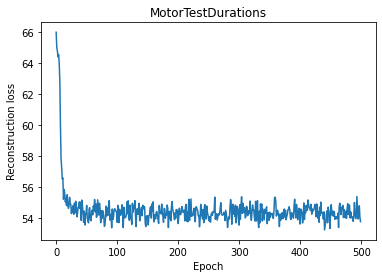

In [9]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
for f in files:
    opts=dict(best_hyper[best_hyper['files'].copy()==f])
    settings=set_settings(opts,modload=False,save=True)
    helpers.train_network(settings)
wave = np.sin(2*np.pi*400*np.arange(10000*2)/10000)
Audio(wave, rate=10000, autoplay=True)

# Get embeddings

In [5]:
dat=list()
dfs=list()
for f in files:
    # replace placeholders in template
    opts=dict(best_hyper[best_hyper['files'].copy()==f])
    opts['nbatch'].iloc[0]=sample_size
    settings=set_settings(opts,nepochs=1,modload=True,save=False)
    
    #run
    encs,encz,d=helpers.enc_network(settings)

    # make deterministic embeddings
    subj=pd.read_csv('python_names/'+re.sub('.csv','',f)+'_subj.csv')['x']
    sc=pd.DataFrame({'scode_'+re.sub('.csv','',f):pd.Series(np.array([i for i in encs])),'SUBJID':subj})  
    zc=pd.DataFrame({'zcode_'+re.sub('.csv','',f):pd.Series(np.array([i[0] for i in encz])),'SUBJID':subj})
    ##change by Meemansa for ALTOIDA version 4(duplicate IDs for some patients)
    enc=pd.merge(sc, zc, on = 'SUBJID')
    #enc=pd.concat([sc, zc], axis=1)
    #enc = enc.iloc[:, :-1]
    ##end of change
    
    # save out individual file's metadata
    
    enc.to_csv('Saved_Networks/'+re.sub('.csv','',f)+'_meta.csv',index = False)
    dfs.append(enc)
    dat.append(d)

# join metadata
enc_vars=[pd.read_csv('Saved_Networks/'+re.sub('.csv','',f)+'_meta.csv') for f in files]
meta=helpers.merge_dat(enc_vars)
meta[meta.columns[['Unnamed' not in i for i in meta.columns]]].to_csv('metaenc.csv',index= False)

dat_dic=dict(zip(files,dat))


NameError: name 'best_hyper' is not defined

In [6]:
meta = pd.read_csv("metaenc.csv", sep = ',')

In [1]:
print((meta.columns))

NameError: name 'meta' is not defined

Text(0.5, 0.98, 'HI-VAE embeddings (deterministic)')

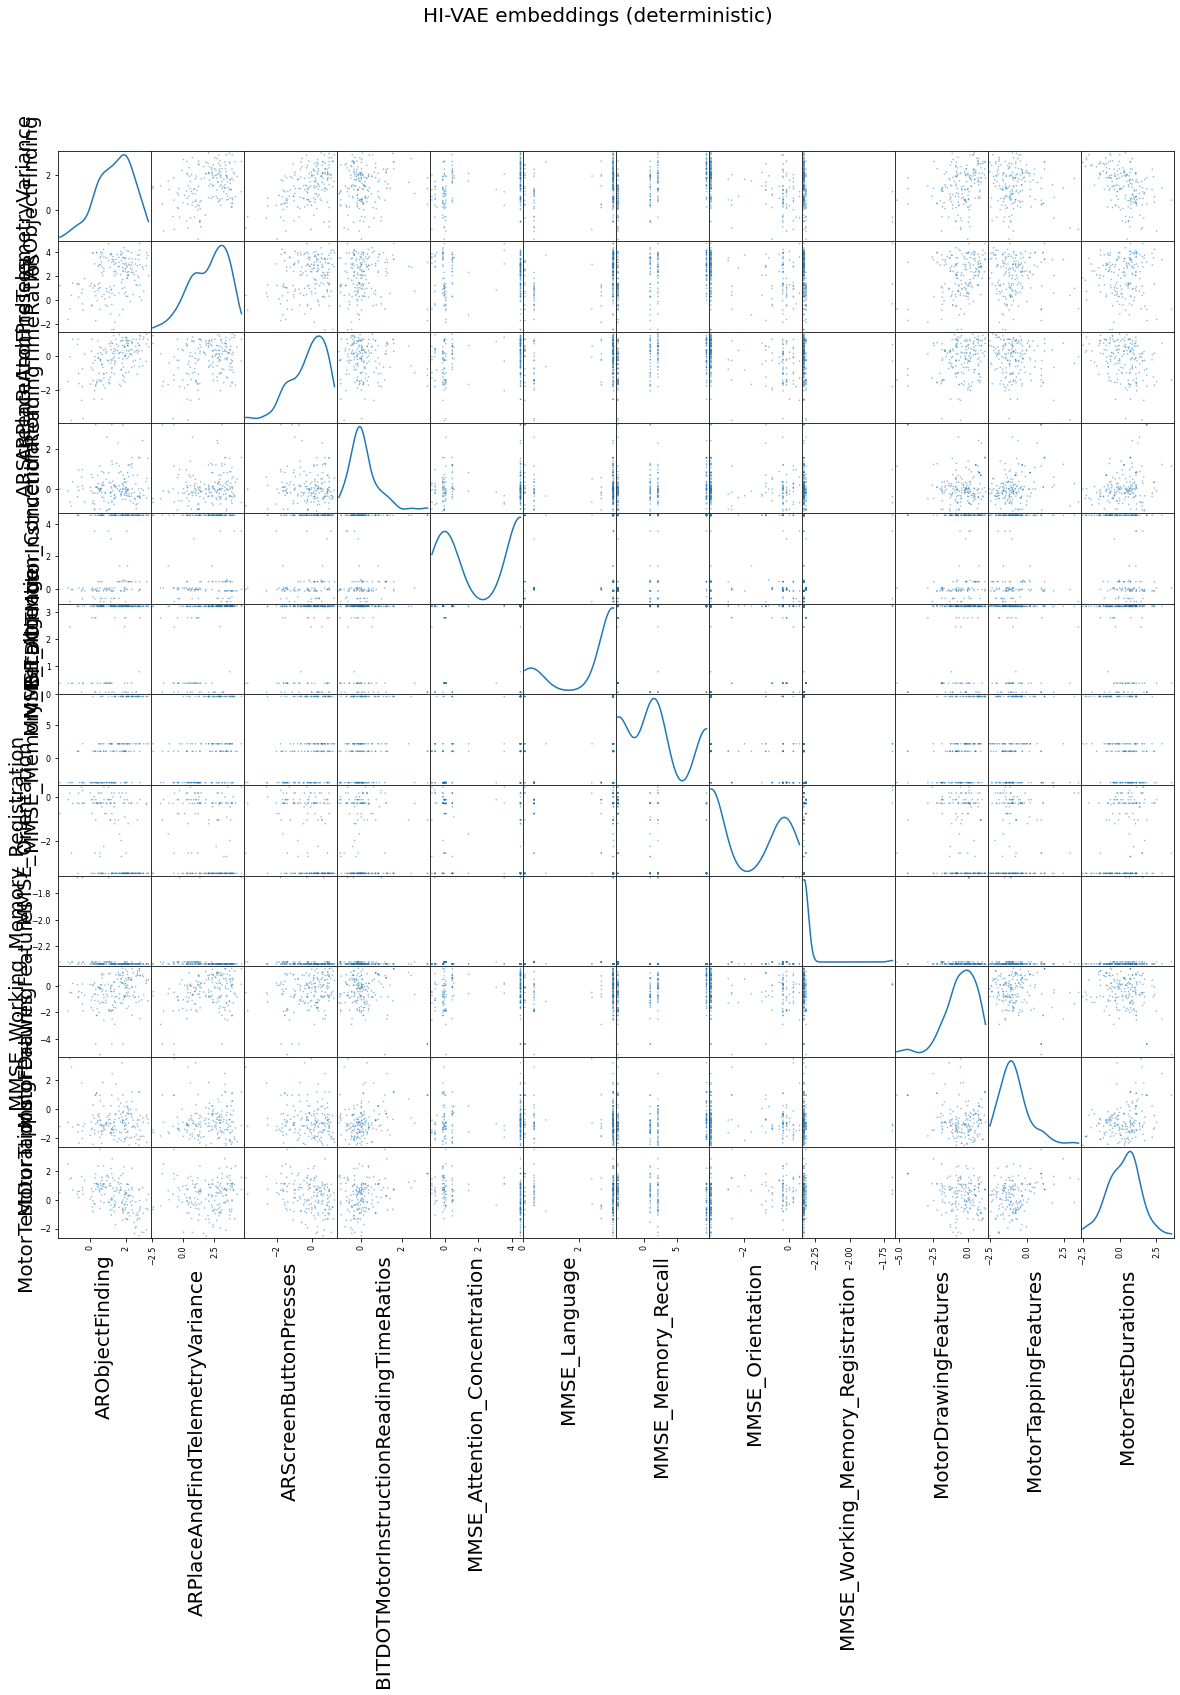

In [13]:
fig = scatter_matrix(
    meta[meta.columns.drop(list(meta.filter(regex='SUBJID|scode_')))],
    figsize  = [20, 20],
    marker   = ".",
    s        = 10,
    diagonal = "kde"
)
for ax in fig.ravel():
    ax.set_xlabel(re.sub('_VIS|zcode_','',ax.get_xlabel()), fontsize = 20, rotation = 90)
    ax.set_ylabel(re.sub('_VIS|zcode_','',ax.get_ylabel()), fontsize = 20, rotation = 90)
    
plt.suptitle('HI-VAE embeddings (deterministic)',fontsize=20)

# RP decoding (Reconstruction)

In [14]:
meta = pd.read_csv('metaenc.csv')
sample_size = 178
recon=list()
recdfs=list()
for f in files:
    # replace placeholders in template
    opts=dict(best_hyper[best_hyper['files'].copy()==f])
    opts['nbatch'].iloc[0]=sample_size
    settings=set_settings(opts,nepochs=1,modload=True,save=False)
    
    #run
    zcodes=meta['zcode_'+re.sub('.csv','',f)]
    scodes=meta['scode_'+re.sub('.csv','',f)]
    rec=helpers.dec_network(settings,zcodes,scodes)
    recon.append(rec)
    
    subj=pd.read_csv('python_names/'+re.sub('.csv','',f)+'_subj.csv')['x']
    names=pd.read_csv('python_names/'+re.sub('.csv','',f)+'_cols.csv')['x']
    recd=pd.DataFrame(rec)
    recd.columns=names
    recd['SUBJID']=subj
    recdfs.append(recd)
    
recon_dic=dict(zip(files,recon))

data_recon=helpers.merge_dat(recdfs)
data_recon.to_csv('reconRP.csv',index=False)

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ARObjectFinding/ARObjectFinding.ckpt
Model restored: ./Saved_Networks/ARObjectFinding/ARObjectFinding.ckpt
::::::DECODING:::::::::
miss_list
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[ 1.          1.         62.859      ...  7.          0.
   0.        ]
 [ 0.          1.         11.799      ...  3.          0.
   0.        ]
 [ 0.          0.         15.60733333 ...  1.          0.
   0.        ]
 ...
 [ 0.          0.          6.79266667 ...  2.          0.
   0.        ]
 [ 0.          0.         10.06866667 ...  0.          0.
   0.        ]
 [ 0.          0.         13.09933333 ...  0.          0.
   0.        ]]
[[ 1.          1.         62.859      ...  7.     

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ARPlaceAndFindTelemetryVariance/ARPlaceAndFindTelemetryVariance.ckpt
Model restored: ./Saved_Networks/ARPlaceAndFindTelemetryVariance/ARPlaceAndFindTelemetryVariance.ckpt
::::::DECODING:::::::::
miss_list
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[1.13858763e-02 1.71628473e-02 1.18008802e-02 ...            nan
             nan            nan]
 [8.14907130e-02 1.43892881e-02 1.43878368e-01 ...            nan
             nan            nan]
 [7.06299919e-03 1.06101326e-02 7.64586552e-02 ... 1.21709101e-02
  2.29202948e+00 5.51916067e-02]
 ...
 [1.77004373e-02 1.64988965e-02 1.57841988e-02 ... 2.15204498e-04
  2.17061528e+00 4.12259607e-03]
 [4.77064835e-02 3.01781887e-03 1.23512438e-02 ... 2.66994504e-04
  1.87030608e+00 2.76410228e-04]
 [

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ARScreenButtonPresses/ARScreenButtonPresses.ckpt
Model restored: ./Saved_Networks/ARScreenButtonPresses/ARScreenButtonPresses.ckpt
::::::DECODING:::::::::
miss_list
[[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
[[1.28900000e+00 6.47200854e-02 0.00000000e+00 ... 3.00000000e+00
  0.00000000e+00 1.00000000e+02]
 [           nan            nan 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+02]
 [8.74500000e-01 1.83182421e-01 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 1.00000000e+02]
 ...
 [1.08150000e+00 1.59567779e-01 1.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 1.00000000e+02]
 [9.03166667e-01 2.86278825e-01 0.00000000e+00 ... 3.00000000e+00
  2

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/BITDOTMotorInstructionReadingTimeRatios/BITDOTMotorInstructionReadingTimeRatios.ckpt
Model restored: ./Saved_Networks/BITDOTMotorInstructionReadingTimeRatios/BITDOTMotorInstructionReadingTimeRatios.ckpt
::::::DECODING:::::::::
miss_list
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
[[1.30364372 0.55843653 1.27608347 0.78163654 0.81343284 1.30301129]
 [2.07018897 2.19565217 1.07587253 1.06777108 1.58941948 0.39647026]
 [0.91590074 0.78507993 0.97004608 0.68697343 1.03609155 0.90875576]
 ...
 [2.81993958 1.57083333 1.12181818 1.65554465 5.23010753 1.76705049]
 [2.81993958 1.57083333 1.12181818 1.65554465 5.23010753 1.76705049]
 [2.81993958 1.57083333 1.12181818 1.65554465 5.23010753 1.76705049]]
[[1.30364372 0.55843653 1.27608347 0.78163654 0.81343284 1.30301129]
 [2.07018897 2.19565217 1.07587253 1.06777108 1.58941

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Attention_Concentration/MMSE_Attention_Concentration.ckpt
Model restored: ./Saved_Networks/MMSE_Attention_Concentration/MMSE_Attention_Concentration.ckpt
::::::DECODING:::::::::
miss_list
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Language/MMSE_Language.ckpt
Model restored: ./Saved_Networks/MMSE_Language/MMSE_Language.ckpt
::::::DECODING:::::::::
miss_list
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Memory_Recall/MMSE_Memory_Recall.ckpt
Model restored: ./Saved_Networks/MMSE_Memory_Recall/MMSE_Memory_Recall.ckpt
::::::DECODING:::::::::
miss_list
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Orientation/MMSE_Orientation.ckpt
Model restored: ./Saved_Networks/MMSE_Orientation/MMSE_Orientation.ckpt
::::::DECODING:::::::::
miss_list
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Working_Memory_Registration/MMSE_Working_Memory_Registration.ckpt
Model restored: ./Saved_Networks/MMSE_Working_Memory_Registration/MMSE_Working_Memory_Registration.ckpt
::::::DECODING:::::::::
miss_list
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MotorDrawingFeatures/MotorDrawingFeatures.ckpt
Model restored: ./Saved_Networks/MotorDrawingFeatures/MotorDrawingFeatures.ckpt
::::::DECODING:::::::::
miss_list
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[2.62738454e-01 3.20645388e-02 5.87044534e-01 ... 7.50902435e+00
  5.98132634e+00 5.15361760e+00]
 [1.67298708e-01 1.27908810e-02 8.09128631e-01 ... 2.01443064e+00
  6.94031446e+00 5.09454277e+00]
 [2.78926802e-01 5.52097299e-02 5.81395349e-01 ... 4.01685475e+00
  9.83146326e+00 9.02842640e+00]
 ...
 [1.55769301e-01 8.91270445e-03 7.47967480e-01 ... 1.48404149e+00
  6.76364239e+00 3.91001569e+00]
 [1.55769301e-01 8.91270445e-03 7.47967480e-01 ... 1.48404149e+00
  6.76364239e+00 3.91001569e+00]
 [1.55769301e-01 8.91270445e-03 7.47967480e-01

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MotorTappingFeatures/MotorTappingFeatures.ckpt
Model restored: ./Saved_Networks/MotorTappingFeatures/MotorTappingFeatures.ckpt
::::::DECODING:::::::::
miss_list
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[3.31196501e+00 2.64774912e+01 8.00000000e+00 ... 1.00000000e+02
  2.35050000e+00 6.72000000e-02]
 [1.99556095e-01 9.20596452e-03 1.90000000e+01 ... 1.06250000e+02
  1.00329412e+00 5.79411765e-02]
 [3.82692302e-01 3.67547437e-02 2.80000000e+01 ... 1.06250000e+02
  6.09529412e-01 4.36470588e-02]
 ...
 [1.98634269e-01 1.14508130e-02 1.50000000e+01 ... 1.06250000e+02
  6.26588235e-01 0.00000000e+00]
 [1.98634269e-01 1.14508130e-02 1.50000000e+01 ... 1.06250000e+02
  6.265

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MotorTestDurations/MotorTestDurations.ckpt
Model restored: ./Saved_Networks/MotorTestDurations/MotorTestDurations.ckpt
::::::DECODING:::::::::
miss_list
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[ 5.152  2.183  0.209 ...  7.851  3.585 13.03 ]
 [ 5.368  2.151  1.917 ...  9.91   2.206 19.312]
 [ 1.993  1.207  1.085 ...  9.327  2.605 13.017]
 ...
 [ 4.667  2.045  1.922 ...  9.533  2.154 12.816]
 [ 4.667  2.045  1.922 ...  9.533  2.154 12.816]
 [ 4.667  2.045  1.922 ...  9.533  2.154 12.816]]
[[ 5.152  2.183  0.209 ...  7.851  3.585 13.03 ]
 [ 5.368  2.151  1.917 ...  9.91   2.206 19.312]
 [ 1.993  1.207  1.085 ...  9.327  2.605 13.017]
 ...
 [ 4.667  2.045  1.922 ...  9.533  2.154 12.816]
 [ 4.667  2.045  1.922 ...  9.533  2.154 12.816]
 [ 4

In [ ]:
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits=3)
kf